Este colab fue adaptado por Arnold Charry y Valeria Palacio.

# Irregular Cutting Stock Problem (ICSP)


## Recepción y digitalización de Moldes

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from scipy.interpolate import splprep, splev
from scipy.spatial import ConvexHull
from shapely.geometry import Point,mapping,LineString
from shapely.ops import unary_union
from shapely.affinity import scale
from shapely import affinity
import math
import pandas as pd
import json
import csv
import time
import logging
import random
import copy
import os
import multiprocessing
import datetime
from rectpack import newPacker
import matplotlib.patches as patches

# Camisa

In [3]:
camisa_talla_s_mc = []
camisa_talla_s_ml = []
camisa_talla_m_mc = []
camisa_talla_m_ml = []
camisa_talla_l_mc = []
camisa_talla_l_ml = []
camisa_talla_xl_mc = []
camisa_talla_xl_ml = []
camisa_talla_2xl_mc = []
camisa_talla_2xl_ml = []

In [4]:
def suavizar_contorno(contorno, s=0.001):
    contorno = contorno[:, 0, :]  # quitar una dimensión innecesaria
    x, y = contorno[:, 0], contorno[:, 1]
    tck, u = splprep([x, y], s=s)
    u_fine = np.linspace(0, 1, 1000)
    x_fine, y_fine = splev(u_fine, tck)
    return np.vstack((x_fine, y_fine)).T

def procesar_imagen_con_hull(ruta_imagen, suavizar_contorno_func):
    """
    Procesa una imagen, suaviza el contorno más grande, genera su convex hull y lo añade a la lista de polígonos.

    Args:
        ruta_imagen (str): La ruta de la imagen a procesar.
        camisa_talla_s_mc (list): Lista donde se almacenarán los polígonos generados.
        suavizar_contorno_func (function): Función que recibe un contorno y lo suaviza usando B-splines.

    Returns:
        poligono cerrado: Polígono que tiene coordenadas'.
    """
    # Cargar la imagen
    imagen = cv2.imread(ruta_imagen)

    # Obtener las dimensiones de la imagen
    alto, ancho, _ = imagen.shape

    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    # Aplicar un filtro gaussiano para suavizar la imagen
    gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Aplicar un umbral adaptativo para binarizar la imagen
    th = cv2.adaptiveThreshold(gray_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Encontrar los contornos en la imagen binarizada
    contornos, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Suponiendo que deseas trabajar con el contorno más grande
    cnt = max(contornos, key=cv2.contourArea)

    # Suavizar el contorno utilizando la función proporcionada
    contorno_suavizado = suavizar_contorno_func(cnt, s=0.01)

    # Encontrar el convex hull (envolvente convexa) del contorno suavizado
    hull = cv2.convexHull(contorno_suavizado.astype(np.float32))

    # Crear un polígono a partir del convex hull
    hull_pts = np.array([p[0] for p in hull])
    poligono_cerrado = Polygon(hull_pts)


    # Dibujar el contorno suavizado
    imagen_rellena = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    cv2.drawContours(imagen_rellena, [hull_pts.astype(np.int32)], -1, (255, 0, 0), 2)

    # Rellenar el área dentro del convex hull
    cv2.fillPoly(imagen_rellena, [hull_pts.astype(np.int32)], (255, 0, 0))

    # Mostrar la imagen con el área rellenada
    plt.figure(figsize=(8, 8))
    plt.imshow(imagen_rellena)
    plt.axis('off')
    plt.title('Contorno Suavizado y Rellenado con Líneas Rectas usando Convex Hull')
    plt.show()
    return poligono_cerrado

In [5]:
def voltear_poligono_derecha(poligono):
    """
    Voltea el polígono 90 grados hacia la derecha.

    Args:
        poligono (Polygon): El polígono original.

    Returns:
        Polygon: El polígono rotado 90 grados hacia la derecha.
    """
    # Obtener los puntos del polígono original
    puntos_originales = np.array(poligono.exterior.coords)

    # Realizar una rotación de 90 grados hacia la derecha
    # Esto implica intercambiar x e y y cambiar el signo de las nuevas coordenadas y
    puntos_volteados = np.copy(puntos_originales)
    puntos_volteados[:, 0], puntos_volteados[:, 1] = puntos_originales[:, 1], -puntos_originales[:, 0]

    # Crear un nuevo polígono con los puntos rotados
    poligono_volteado = Polygon(puntos_volteados)

    return poligono_volteado

In [6]:
def rotar_poligono_180_grados(poligono):
    """
    Rota el polígono 180 grados.

    Args:
        poligono (Polygon): El polígono original.

    Returns:
        Polygon: El polígono rotado 180 grados.
    """
    # Obtener los puntos del polígono original
    puntos_originales = np.array(poligono.exterior.coords)

    # Rotar 180 grados (invertir el signo de x e y)
    puntos_rotados = np.copy(puntos_originales)
    puntos_rotados[:, 0] = -puntos_rotados[:, 0]  # Invertir coordenadas x
    puntos_rotados[:, 1] = -puntos_rotados[:, 1]  # Invertir coordenadas y

    # Crear un nuevo polígono con los puntos rotados
    poligono_rotado = Polygon(puntos_rotados)

    return poligono_rotado

In [7]:
from shapely.geometry import Polygon
import numpy as np

def rotar_poligono_90_grados_izquierda(poligono):
    """
    Rota el polígono 90 grados a la izquierda (en sentido antihorario).

    Args:
        poligono (Polygon): El polígono original.

    Returns:
        Polygon: El polígono rotado 90 grados a la izquierda.
    """
    # Obtener los puntos del polígono original
    puntos_originales = np.array(poligono.exterior.coords)

    # Rotar 90 grados a la izquierda
    puntos_rotados = np.copy(puntos_originales)
    puntos_rotados[:, 0] = -puntos_originales[:, 1]  # Nuevo x es el negativo del antiguo y
    puntos_rotados[:, 1] = puntos_originales[:, 0]   # Nuevo y es el antiguo x

    # Crear un nuevo polígono con los puntos rotados
    poligono_rotado = Polygon(puntos_rotados)

    return poligono_rotado

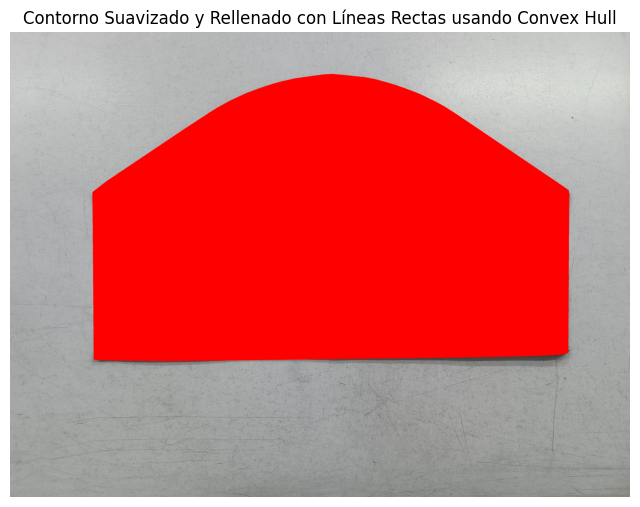

In [8]:
ruta_imagen = 'inputs/Manga corta.jpg'
poligono = procesar_imagen_con_hull(ruta_imagen, suavizar_contorno)

In [9]:
def procesar_imagen_calcular_area(ruta_imagen, suavizar_contorno_func, ancho_real_cm, largo_real_cm):
    """
    Procesa una imagen, suaviza el contorno más grande, genera su convex hull, y calcula
    el área en píxeles y en centímetros cuadrados.

    Args:
        ruta_imagen (str): La ruta de la imagen a procesar.
        suavizar_contorno_func (function): Función que recibe un contorno y lo suaviza.
        ancho_real_cm (float): Ancho real del objeto en la imagen en centímetros.
        largo_real_cm (float): Largo real del objeto en la imagen en centímetros.
    """
    # Cargar la imagen
    imagen = cv2.imread(ruta_imagen)

    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    # Aplicar un filtro gaussiano para suavizar la imagen
    gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Aplicar un umbral adaptativo para binarizar la imagen
    th = cv2.adaptiveThreshold(gray_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

    # Encontrar los contornos en la imagen binarizada
    contornos, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Suponiendo que deseas trabajar con el contorno más grande
    cnt = max(contornos, key=cv2.contourArea)

    # Suavizar el contorno utilizando la función proporcionada
    contorno_suavizado = suavizar_contorno_func(cnt, s=0.01)

    # Encontrar el convex hull (envolvente convexa) del contorno suavizado
    hull = cv2.convexHull(contorno_suavizado.astype(np.float32))

    # Crear un polígono a partir del convex hull
    hull_pts = np.array([p[0] for p in hull])
    poligono_cerrado = Polygon(hull_pts)

    # Dibujar el contorno suavizado
    imagen_rellena = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    cv2.drawContours(imagen_rellena, [hull_pts.astype(np.int32)], -1, (255, 0, 0), 2)

    # Rellenar el área dentro del convex hull
    cv2.fillPoly(imagen_rellena, [hull_pts.astype(np.int32)], (255, 0, 0))

    # Obtener las dimensiones de la imagen
    alto, ancho, _ = imagen.shape

    # Calcular el número total de píxeles en la imagen
    pixeles_totales = alto * ancho

    # Calcular las dimensiones del contorno suavizado
    x_min = np.min(contorno_suavizado[:, 0])
    x_max = np.max(contorno_suavizado[:, 0])
    y_min = np.min(contorno_suavizado[:, 1])
    y_max = np.max(contorno_suavizado[:, 1])

    # Calcular ancho y largo en píxeles
    ancho_pixeles = x_max - x_min
    largo_pixeles = y_max - y_min

    # Calcular la relación de píxeles a centímetros
    pixeles_por_cm_ancho = ancho_pixeles / ancho_real_cm
    pixeles_por_cm_largo = largo_pixeles / largo_real_cm

    # Calcular la relación de píxeles por cm²
    pixeles_por_cm2 = pixeles_por_cm_ancho * pixeles_por_cm_largo

    # Calcular el área en píxeles cuadrados del polígono
    area_pixeles = poligono_cerrado.area

    # Calcular el área en centímetros cuadrados
    area_cm_cuadrados = area_pixeles / pixeles_por_cm2

    # Calcular la relación porcentual
    relacion_porcentual = (area_pixeles / pixeles_totales)

    # Mostrar la imagen con el área rellenada
    plt.figure(figsize=(8, 8))
    plt.imshow(imagen_rellena)
    plt.axis('off')
    plt.title('Contorno Suavizado y Rellenado con Líneas Rectas usando Convex Hull')
    plt.show()

    # Imprimir los resultados
    print("Ancho en píxeles:", ancho_pixeles)
    print("Largo en píxeles:", largo_pixeles)
    print("Total de píxeles en la imagen:", pixeles_totales)
    print("Relación píxeles/cm (ancho):", pixeles_por_cm_ancho)
    print("Relación píxeles/cm (largo):", pixeles_por_cm_largo)
    print("Relación píxeles/cm²:", pixeles_por_cm2)
    print("Área en píxeles cuadrados:", area_pixeles)
    print("Área en cm cuadrados:", area_cm_cuadrados)
    print("Relación porcentual del área:", relacion_porcentual)
    return area_cm_cuadrados


In [10]:
def cambiar_dimensiones_poligono(poligono, ancho_objetivo, alto_objetivo, lista_objetivo):
    """
    Escala un polígono a las dimensiones especificadas (ancho y alto) y lo visualiza con matplotlib.

    Args:
        poligono (Polygon): Polígono original.
        ancho_objetivo (float): Nuevo ancho deseado.
        alto_objetivo (float): Nuevo alto deseado.
        lista_objetivo (list): Lista donde se almacenarán las coordenadas de los polígonos.

    Returns:
        Polygon: Polígono escalado con las nuevas dimensiones.
    """
    # Obtener las dimensiones actuales del polígono
    minx, miny, maxx, maxy = poligono.bounds
    ancho_actual = maxx - minx
    alto_actual = maxy - miny

    # Calcular los factores de escala para ajustar las dimensiones
    escala_x = ancho_objetivo / ancho_actual
    escala_y = alto_objetivo / alto_actual

    # Escalar el polígono con los factores de escala calculados
    poligono_escalado = scale(poligono, xfact=escala_x, yfact=escala_y, origin=(minx, miny))

    # Agregar el polígono a la lista
    lista_objetivo.append([list(coord) for coord in poligono_escalado.exterior.coords])

    # Visualizar solo el polígono escalado
    fig, ax = plt.subplots()

    # Dibujar el polígono escalado
    x_escalado, y_escalado = poligono_escalado.exterior.xy
    ax.plot(x_escalado, y_escalado, 'r-', label='Polígono Escalado')

    # Configuraciones de la visualización
    ax.set_title('Polígono Escalado')
    ax.set_aspect('equal', 'box')

    # Mostrar la gráfica
    plt.show()

    return poligono_escalado

In [11]:
def calcular_area_talla_diferente(area_original, largo_original, ancho_original, largo_nuevo, ancho_nuevo):
    # Calcular proporciones de escala
    proporcion_escala_largo = largo_nuevo / largo_original
    proporcion_escala_ancho = ancho_nuevo / ancho_original

    # Calcular área para la talla M
    area_nueva = area_original * proporcion_escala_largo * proporcion_escala_ancho
    return area_nueva

## Talla S

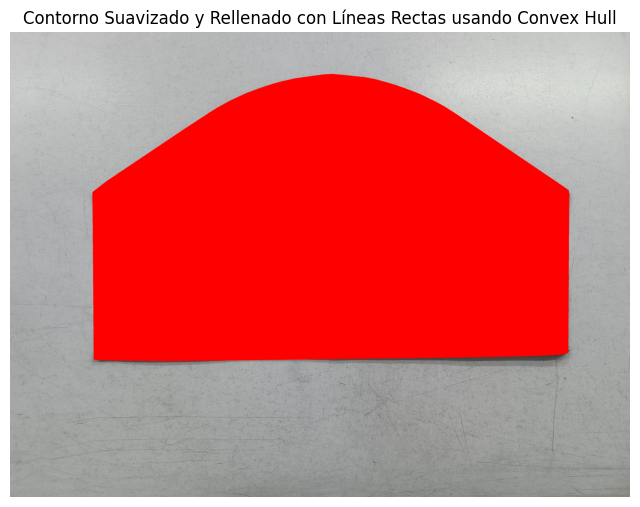

Ancho en píxeles: 3073.0738398888016
Largo en píxeles: 1851.6819633284247
Total de píxeles en la imagen: 12000000
Relación píxeles/cm (ancho): 85.36316221913337
Relación píxeles/cm (largo): 80.50791144906194
Relación píxeles/cm²: 6872.409904949899
Área en píxeles cuadrados: 4750460.527138498
Área en cm cuadrados: 691.2364938705049
Relación porcentual del área: 0.3958717105948748
Área estimada para la talla S: 691.2364938705049 cm²


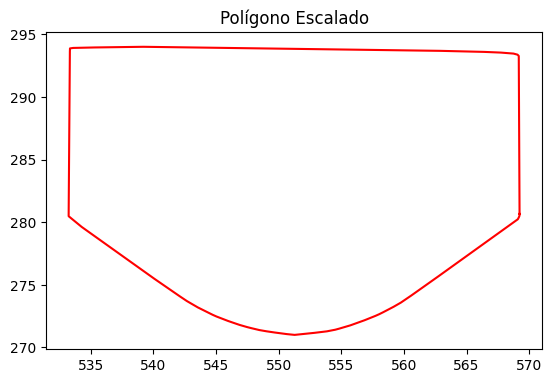

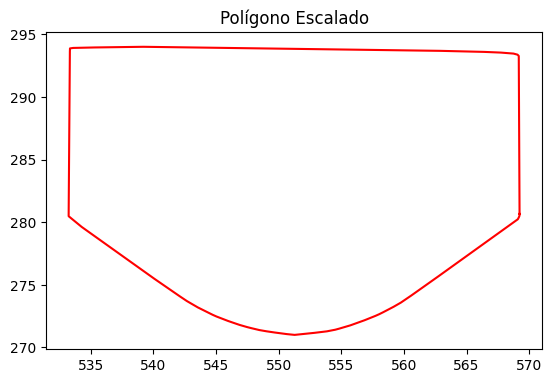

In [12]:
# Definir las nuevas dimensiones deseadas
ruta_imagen = 'inputs/Manga corta.jpg'
ancho_S = 36  # Ancho objetivo
largo_S = 23  # Alto objetivo

área_S = procesar_imagen_calcular_area(ruta_imagen, suavizar_contorno, ancho_S, largo_S)
print("Área estimada para la talla S:", área_S, "cm²")

# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(poligono, ancho_S, largo_S, camisa_talla_s_mc)
poligono_escalado1 = cambiar_dimensiones_poligono(poligono, ancho_S, largo_S, camisa_talla_s_mc)

## Talla M

Área estimada para la talla M: 807.9035228782382 cm²


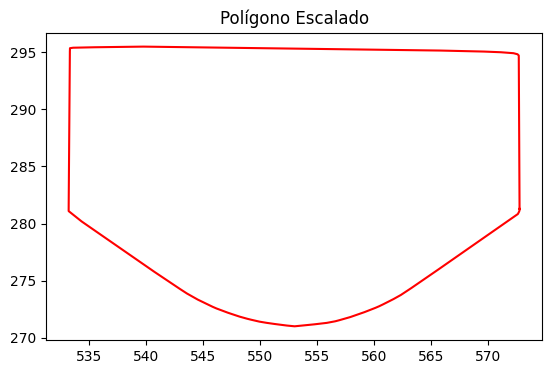

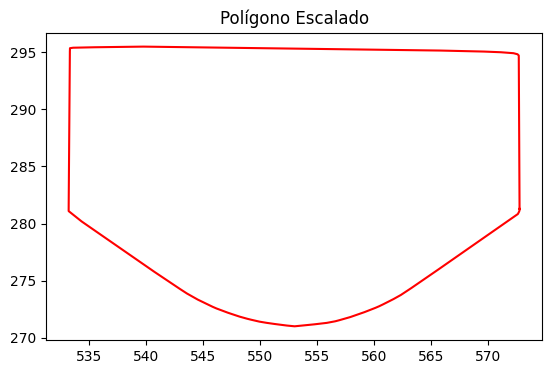

In [13]:
# Definir las nuevas dimensiones deseadas
ancho_M = 39.5  # Ancho objetivo
largo_M = 24.5  # Alto objetivo

# Calcular el área para la talla M
area_M = calcular_area_talla_diferente(área_S , largo_S, ancho_S, largo_M, ancho_M)
print("Área estimada para la talla M:", area_M, "cm²")


# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(poligono, ancho_M, largo_M, camisa_talla_m_mc)
poligono_escalado1 = cambiar_dimensiones_poligono(poligono, ancho_M, largo_M, camisa_talla_m_mc)

## Talla L

Área estimada para la talla L: 855.6973505039463 cm²


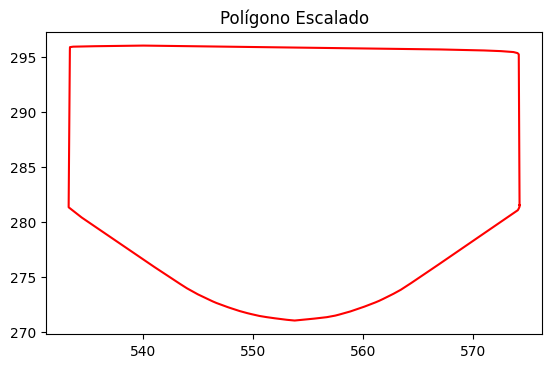

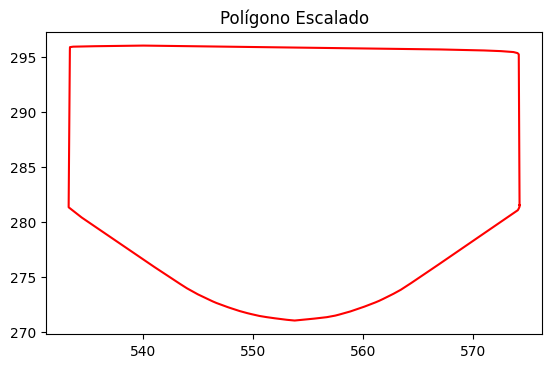

In [14]:
# Definir las nuevas dimensiones deseadas
ancho_L = 41  # Ancho objetivo
largo_L = 25  # Alto objetivo

# Calcular el área para la talla L
area_L = calcular_area_talla_diferente(área_S , largo_S, ancho_S, largo_L, ancho_L)
print("Área estimada para la talla L:", area_L, "cm²")

# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(poligono, ancho_L, largo_L, camisa_talla_l_mc)
poligono_escalado1 = cambiar_dimensiones_poligono(poligono, ancho_L, largo_L, camisa_talla_l_mc)

## Talla XL

Área estimada para la talla L: 951.2850057553626 cm²


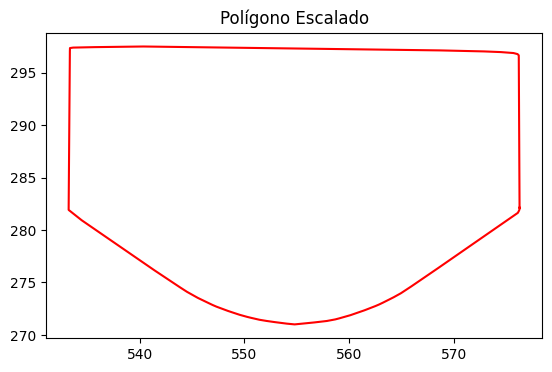

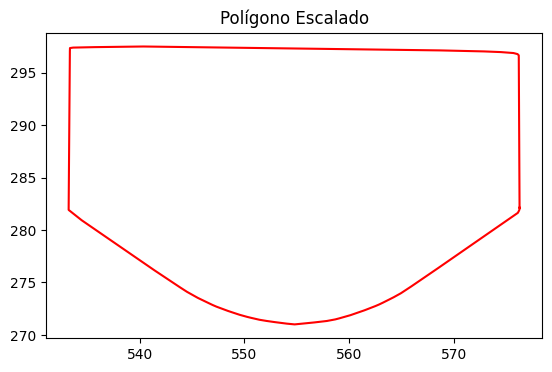

In [15]:
# Definir las nuevas dimensiones deseadas
ancho_XL = 43  # Ancho objetivo
largo_XL = 26.5  # Alto objetivo

# Calcular el área para la talla L
area_XL = calcular_area_talla_diferente(área_S , largo_S, ancho_S, largo_XL, ancho_XL)
print("Área estimada para la talla L:", area_XL, "cm²")

# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(poligono, ancho_XL, largo_XL, camisa_talla_xl_mc)
poligono_escalado1 = cambiar_dimensiones_poligono(poligono, ancho_XL, largo_XL, camisa_talla_xl_mc)

## Talla 2XL

Área estimada para la talla L: 1095.918728657615 cm²


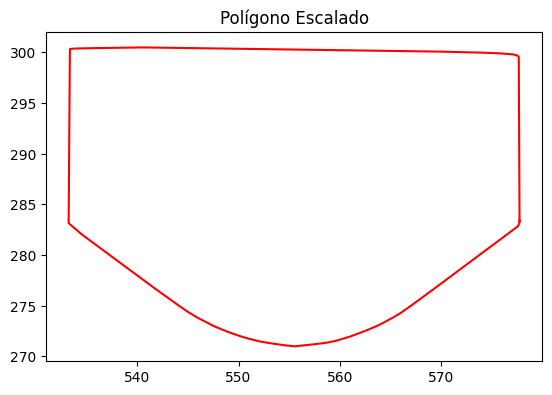

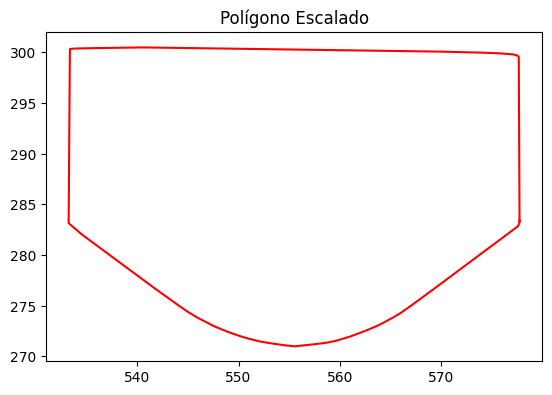

In [16]:
# Definir las nuevas dimensiones deseadas
ancho_2XL = 44.5 # Ancho objetivo
largo_2XL = 29.5  # Alto objetivo

# Calcular el área para la talla L
area_2XL = calcular_area_talla_diferente(área_S , largo_S, ancho_S, largo_2XL, ancho_2XL)
print("Área estimada para la talla L:", area_2XL, "cm²")

# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(poligono, ancho_2XL, largo_2XL, camisa_talla_2xl_mc)
poligono_escalado1 = cambiar_dimensiones_poligono(poligono, ancho_2XL, largo_2XL, camisa_talla_2xl_mc)

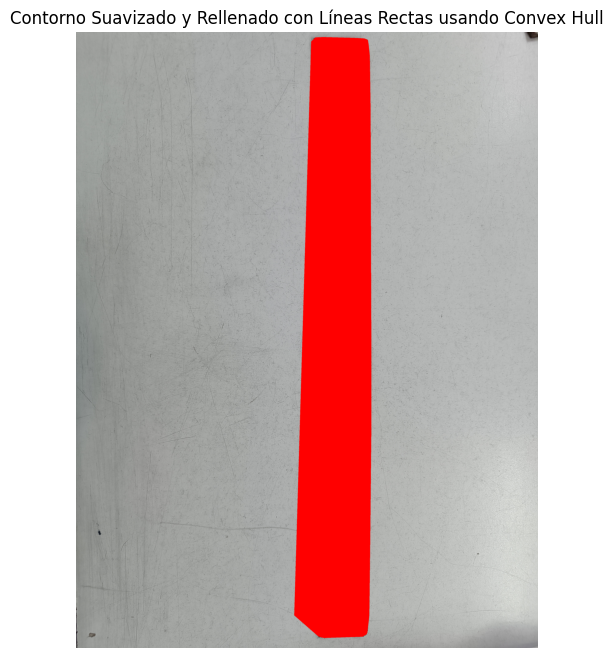

In [17]:
ruta_imagen = 'inputs/Cuello.jpg'
poligono = procesar_imagen_con_hull(ruta_imagen, suavizar_contorno)
polygon = voltear_poligono_derecha(poligono)

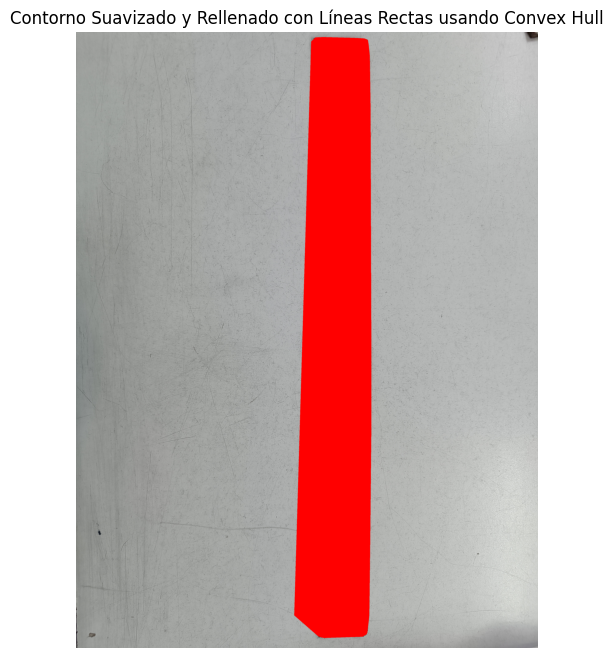

Ancho en píxeles: 498.2548091803458
Largo en píxeles: 3898.934409001091
Total de píxeles en la imagen: 12000000
Relación píxeles/cm (ancho): 110.72329092896572
Relación píxeles/cm (largo): 79.5700899796141
Relación píxeles/cm²: 8810.262222056792
Área en píxeles cuadrados: 1698743.6753424536
Área en cm cuadrados: 192.81420149897366
Relación porcentual del área: 0.14156197294520448


In [18]:
# Llamada a la función
ruta_imagen = 'inputs/Cuello.jpg'
ancho_real_cm = 4.5  # Ejemplo de ancho real en cm
largo_real_cm = 49  # Ejemplo de largo real en cm

resultados = procesar_imagen_calcular_area(ruta_imagen, suavizar_contorno, ancho_real_cm, largo_real_cm)

## Talla S

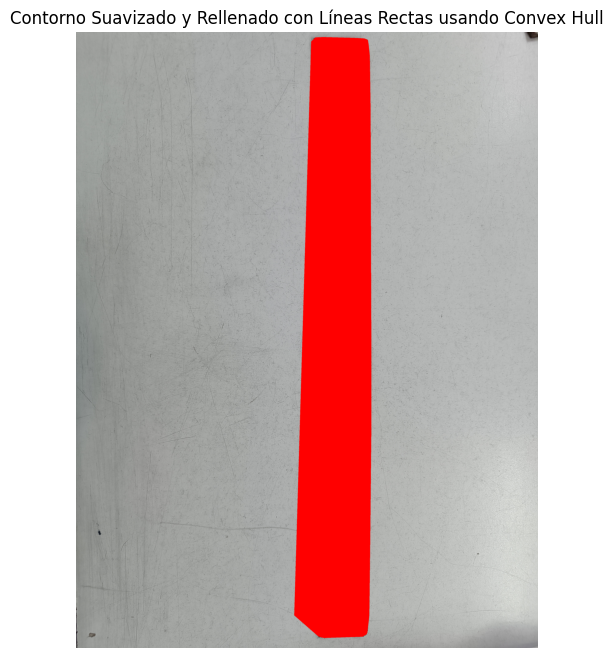

Ancho en píxeles: 498.2548091803458
Largo en píxeles: 3898.934409001091
Total de píxeles en la imagen: 12000000
Relación píxeles/cm (ancho): 10.168465493476445
Relación píxeles/cm (largo): 866.4298686669091
Relación píxeles/cm²: 8810.262222056794
Área en píxeles cuadrados: 1698743.6753424536
Área en cm cuadrados: 192.8142014989736
Relación porcentual del área: 0.14156197294520448
Área estimada para la talla S: 192.8142014989736 cm²


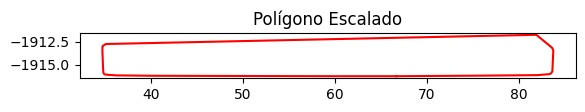

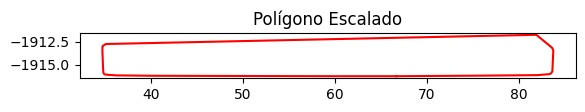

In [19]:
# Definir las nuevas dimensiones deseadas
ancho_S = 49  # Ancho objetivo
largo_S = 4.5  # Alto objetivo

área_S = procesar_imagen_calcular_area(ruta_imagen, suavizar_contorno, ancho_S, largo_S)
print("Área estimada para la talla S:", área_S, "cm²")

# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(polygon, ancho_S, largo_S, camisa_talla_s_mc)
poligono_escalado1 = cambiar_dimensiones_poligono(polygon, ancho_S, largo_S, camisa_talla_s_ml)

## Talla M

Área estimada para la talla M: 200.68416890709497 cm²


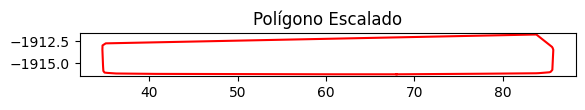

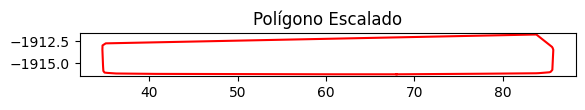

In [20]:
# Definir las nuevas dimensiones deseadas
ancho_M = 51  # Ancho objetivo
largo_M = 4.5  # Alto objetivo

# Calcular el área para la talla M
area_M = calcular_area_talla_diferente(área_S , largo_S, ancho_S, largo_M, ancho_M)
print("Área estimada para la talla M:", area_M, "cm²")
# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(polygon, ancho_M, largo_M, camisa_talla_m_mc)
poligono_escalado1 = cambiar_dimensiones_poligono(polygon, ancho_M, largo_M, camisa_talla_m_ml)

##Talla L

Área estimada para la talla L: 208.55413631521637 cm²


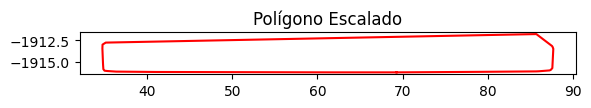

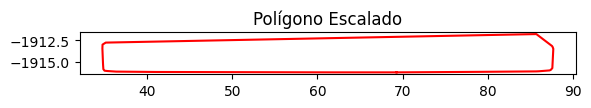

In [21]:
# Definir las nuevas dimensiones deseadas
ancho_L = 53  # Ancho objetivo
largo_L = 4.5  # Alto objetivo

# Calcular el área para la talla L
area_L = calcular_area_talla_diferente(área_S , largo_S, ancho_S, largo_L, ancho_L)
print("Área estimada para la talla L:", area_L, "cm²")

# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(polygon, ancho_L, largo_L, camisa_talla_l_mc)
poligono_escalado1 = cambiar_dimensiones_poligono(polygon, ancho_L, largo_L, camisa_talla_l_ml)

## Talla XL

Área estimada para la talla L: 212.489120019277 cm²


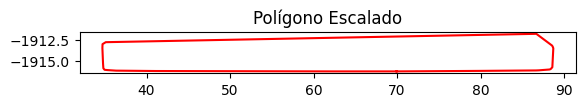

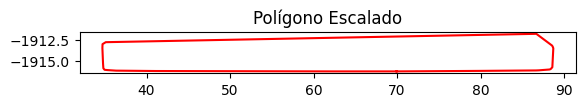

In [22]:
# Definir las nuevas dimensiones deseadas
ancho_XL = 54  # Ancho objetivo
largo_XL = 4.5  # Alto objetivo

# Calcular el área para la talla L
area_XL = calcular_area_talla_diferente(área_S , largo_S, ancho_S, largo_XL, ancho_XL)
print("Área estimada para la talla L:", area_XL, "cm²")

# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(polygon, ancho_XL, largo_XL, camisa_talla_xl_mc)
poligono_escalado1 = cambiar_dimensiones_poligono(polygon, ancho_XL, largo_XL, camisa_talla_xl_ml)

## Talla 2XL

Área estimada para la talla L: 228.22905483551978 cm²


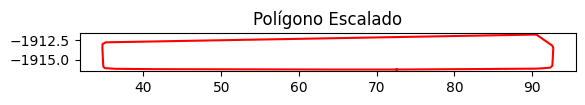

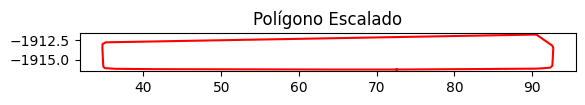

In [23]:
# Definir las nuevas dimensiones deseadas
ancho_2XL = 58 # Ancho objetivo
largo_2XL = 4.5  # Alto objetivo

# Calcular el área para la talla L
area_2XL = calcular_area_talla_diferente(área_S , largo_S, ancho_S, largo_2XL, ancho_2XL)
print("Área estimada para la talla L:", area_2XL, "cm²")

# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(polygon, ancho_2XL, largo_2XL, camisa_talla_2xl_mc)
poligono_escalado1 = cambiar_dimensiones_poligono(polygon, ancho_2XL, largo_2XL, camisa_talla_2xl_ml)

In [24]:
def procesar_imagen_con_hull_y_contorno(ruta_imagen, suavizar_contorno_func):
    """
    Procesa una imagen, suaviza el contorno más grande, genera su convex hull, y lo añade a la lista de polígonos.

    Args:
        ruta_imagen (str): La ruta de la imagen a procesar.
        camisa_talla_s_mc (list): Lista donde se almacenarán los polígonos generados.
        suavizar_contorno_func (function): Función que recibe un contorno y lo suaviza usando B-splines.

    Returns:
        poligono_cerrado: el poligono.
    """
    # Cargar la imagen
    imagen = cv2.imread(ruta_imagen)

    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    # Aplicar un filtro gaussiano para suavizar la imagen
    gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Aplicar un umbral adaptativo para binarizar la imagen
    th = cv2.adaptiveThreshold(gray_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

    # Encontrar los contornos en la imagen binarizada
    contornos, hierarchy = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Suponiendo que deseas trabajar con el contorno más grande
    cnt = max(contornos, key=cv2.contourArea)

    # Suavizar el contorno utilizando la función proporcionada
    contorno_suavizado = suavizar_contorno_func(cnt, s=0.01)

    # Encontrar el convex hull (envolvente convexa) del contorno suavizado
    hull = cv2.convexHull(contorno_suavizado.astype(np.float32))

    # Crear un polígono a partir del convex hull
    hull_pts = np.array([p[0] for p in hull])
    poligono_cerrado = Polygon(hull_pts)

    # Dibujar el contorno suavizado
    imagen_rellena = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    cv2.drawContours(imagen_rellena, [hull_pts.astype(np.int32)], -1, (255, 0, 0), 2)

    # Rellenar el área dentro del convex hull
    cv2.fillPoly(imagen_rellena, [hull_pts.astype(np.int32)], (255, 0, 0))

    # Mostrar la imagen con el área rellenada
    plt.figure(figsize=(8, 8))
    plt.imshow(imagen_rellena)
    plt.axis('off')
    plt.title('Contorno Suavizado y Rellenado con Líneas Rectas usando Convex Hull')
    plt.show()
    return poligono_cerrado

/Users/danielmartinezvillegas/anaconda3/envs/personal/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:298: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


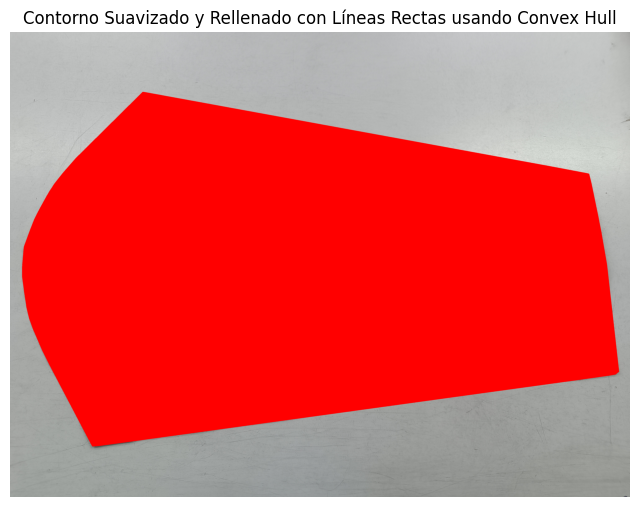

In [25]:
# Llamada a la función
ruta_imagen = 'inputs/Manga larga.jpg'
poligono = procesar_imagen_con_hull_y_contorno(ruta_imagen, suavizar_contorno)
polygon = rotar_poligono_90_grados_izquierda(poligono)

In [26]:
def procesar_imagen_calcular_area_y_mostrar(ruta_imagen, suavizar_contorno_func, ancho_real_cm, largo_real_cm):
    """
    Procesa una imagen, suaviza el contorno más grande, genera su convex hull, y calcula
    el área en píxeles y en centímetros cuadrados. Muestra la imagen y las relaciones calculadas.

    Args:
        ruta_imagen (str): La ruta de la imagen a procesar.
        suavizar_contorno_func (function): Función que recibe un contorno y lo suaviza.
        ancho_real_cm (float): Ancho real del objeto en la imagen en centímetros.
        largo_real_cm (float): Largo real del objeto en la imagen en centímetros.

    Returns:
        float: Área en centímetros cuadrados de la figura.
    """
    # Cargar la imagen
    imagen = cv2.imread(ruta_imagen)
    print("Imagen cargada.")

    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    print("Imagen convertida a escala de grises.")

    # Aplicar un filtro gaussiano para suavizar la imagen
    gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    print("Filtro gaussiano aplicado.")

    # Aplicar un umbral adaptativo para binarizar la imagen
    th = cv2.adaptiveThreshold(gray_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)
    print("Umbral adaptativo aplicado.")

    # Encontrar los contornos en la imagen binarizada
    contornos, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Número de contornos encontrados: {len(contornos)}")

    # Suponiendo que deseas trabajar con el contorno más grande
    cnt = max(contornos, key=cv2.contourArea)
    print("Contorno más grande seleccionado.")

    # Suavizar el contorno utilizando la función proporcionada
    contorno_suavizado = suavizar_contorno_func(cnt)
    print("Contorno suavizado.")

    # Encontrar el convex hull (envolvente convexa) del contorno suavizado
    hull = cv2.convexHull(contorno_suavizado.astype(np.float32))
    print("Convex hull generado.")

    # Crear un polígono a partir del convex hull
    hull_pts = np.array([p[0] for p in hull])
    poligono_cerrado = Polygon(hull_pts)
    print("Polígono creado a partir del convex hull.")

    # Dibujar el contorno suavizado
    imagen_rellena = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    cv2.drawContours(imagen_rellena, [hull_pts.astype(np.int32)], -1, (255, 0, 0), 2)
    print("Contorno dibujado en la imagen.")

    # Rellenar el área dentro del convex hull
    cv2.fillPoly(imagen_rellena, [hull_pts.astype(np.int32)], (255, 0, 0))
    print("Área dentro del convex hull rellenada.")

    # Calcular el área en píxeles cuadrados del polígono
    area_pixeles = poligono_cerrado.area
    print(f"Área en píxeles cuadrados: {area_pixeles}")

    # Obtener las dimensiones del contorno suavizado
    x_min, x_max = np.min(contorno_suavizado[:, 0]), np.max(contorno_suavizado[:, 0])
    y_min, y_max = np.min(contorno_suavizado[:, 1]), np.max(contorno_suavizado[:, 1])
    print(f"Dimensiones del contorno: x_min={x_min}, x_max={x_max}, y_min={y_min}, y_max={y_max}")

    # Calcular ancho y largo en píxeles
    ancho_pixeles = x_max - x_min
    largo_pixeles = y_max - y_min
    print(f"Ancho en píxeles: {ancho_pixeles}, Largo en píxeles: {largo_pixeles}")

    # Calcular la relación de píxeles a centímetros
    pixeles_por_cm_ancho = ancho_pixeles / ancho_real_cm
    pixeles_por_cm_largo = largo_pixeles / largo_real_cm
    print(f"Relación de píxeles por cm - Ancho: {pixeles_por_cm_ancho}, Largo: {pixeles_por_cm_largo}")

    # Calcular la relación de píxeles por cm²
    pixeles_por_cm2 = pixeles_por_cm_ancho * pixeles_por_cm_largo
    print(f"Relación de píxeles por cm²: {pixeles_por_cm2}")

    # Calcular el área en centímetros cuadrados
    area_cm_cuadrados = area_pixeles / pixeles_por_cm2
    print(f"Área en centímetros cuadrados: {area_cm_cuadrados}")

    # Mostrar la imagen con el área rellenada
    plt.figure(figsize=(8, 8))
    plt.imshow(imagen_rellena)
    plt.axis('off')
    plt.title('Contorno Suavizado y Rellenado con Líneas Rectas usando Convex Hull')
    plt.show()

    return area_cm_cuadrados

## Talla S

Imagen cargada.
Imagen convertida a escala de grises.
Filtro gaussiano aplicado.
Umbral adaptativo aplicado.
Número de contornos encontrados: 36612
Contorno más grande seleccionado.
Contorno suavizado.
Convex hull generado.
Polígono creado a partir del convex hull.
Contorno dibujado en la imagen.
Área dentro del convex hull rellenada.
Área en píxeles cuadrados: 6524115.283902335
Dimensiones del contorno: x_min=79.50282069129392, x_max=3928.1241011011575, y_min=387.00000015611573, y_max=2672.7639929382526
Ancho en píxeles: 3848.6212804098636, Largo en píxeles: 2285.763992782137
Relación de píxeles por cm - Ancho: 63.09215213786662, Largo: 60.15168402058255
Relación de píxeles por cm²: 3795.099199575475
Área en centímetros cuadrados: 1719.0895259423341


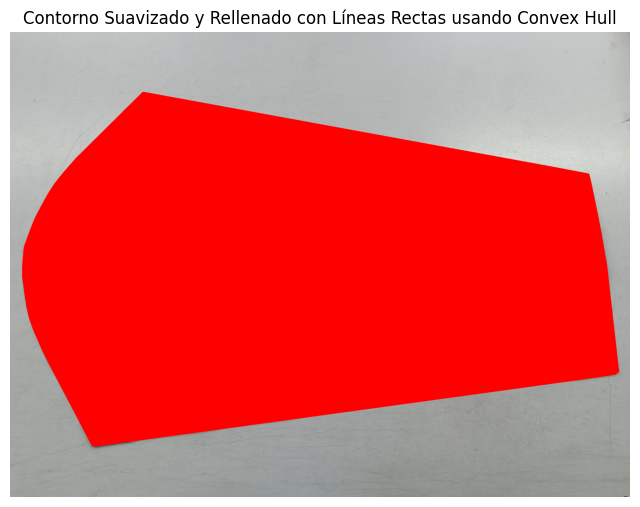

1719.0895259423341

In [27]:
# Llamada a la función
ruta_imagen = 'inputs/Manga larga.jpg'
ancho_S = 61  # Ancho real en cm
largo_S = 38  # Largo real en cm

procesar_imagen_calcular_area_y_mostrar(ruta_imagen, suavizar_contorno, ancho_S, largo_S)

## Talla S

Imagen cargada.
Imagen convertida a escala de grises.
Filtro gaussiano aplicado.
Umbral adaptativo aplicado.
Número de contornos encontrados: 36612
Contorno más grande seleccionado.
Contorno suavizado.
Convex hull generado.
Polígono creado a partir del convex hull.
Contorno dibujado en la imagen.
Área dentro del convex hull rellenada.
Área en píxeles cuadrados: 6524115.283902335
Dimensiones del contorno: x_min=79.50282069129392, x_max=3928.1241011011575, y_min=387.00000015611573, y_max=2672.7639929382526
Ancho en píxeles: 3848.6212804098636, Largo en píxeles: 2285.763992782137
Relación de píxeles por cm - Ancho: 101.27950737920693, Largo: 37.471540865280936
Relación de píxeles por cm²: 3795.099199575475
Área en centímetros cuadrados: 1719.0895259423341


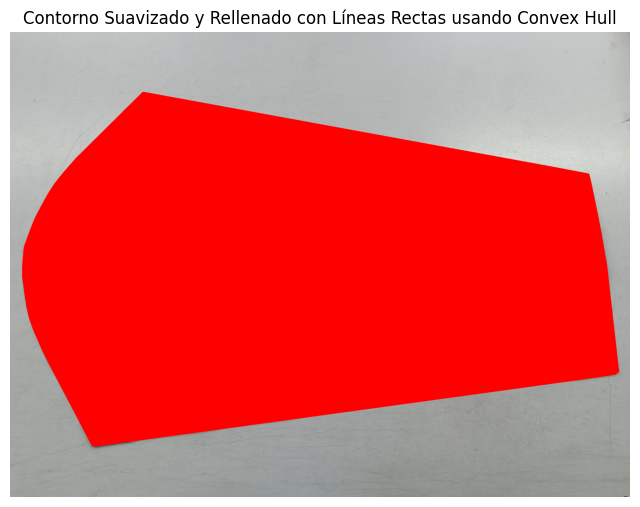

Área estimada para la talla S: 1719.0895259423341 cm²


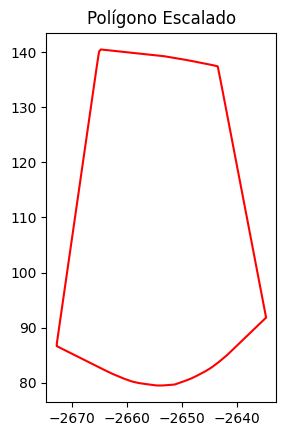

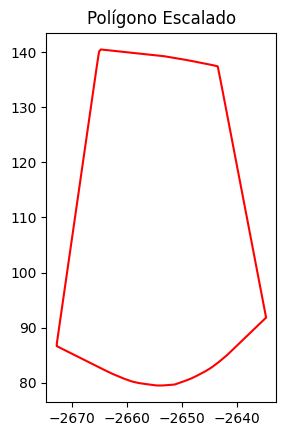

In [28]:
# Definir las nuevas dimensiones deseadas
ancho_S = 38  # Ancho objetivo
largo_S = 61 # Alto objetivo

área_S = procesar_imagen_calcular_area_y_mostrar(ruta_imagen, suavizar_contorno, ancho_S, largo_S)
print("Área estimada para la talla S:", área_S, "cm²")

# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(polygon, ancho_S, largo_S, camisa_talla_s_ml)
poligono_escalado1 = cambiar_dimensiones_poligono(polygon, ancho_S, largo_S, camisa_talla_s_ml)

## Talla M

Área estimada para la talla M: 1854.0654938981168 cm²


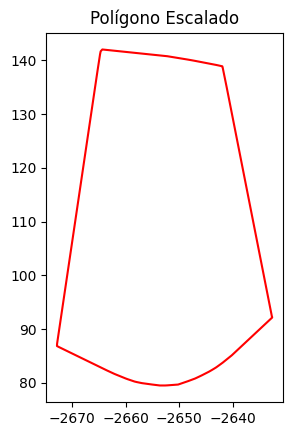

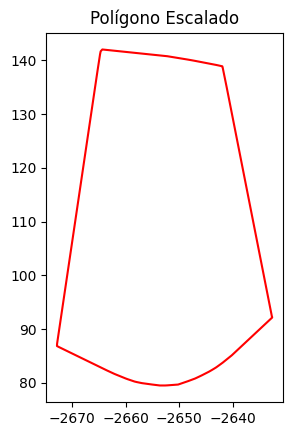

In [29]:
# Definir las nuevas dimensiones deseadas
ancho_M = 40  # Ancho objetivo
largo_M = 62.5  # Alto objetivo

# Calcular el área para la talla M
area_M = calcular_area_talla_diferente(área_S , largo_S, ancho_S, largo_M, ancho_M)
print("Área estimada para la talla M:", area_M, "cm²")
# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(polygon, ancho_M, largo_M, camisa_talla_m_ml)
poligono_escalado1 = cambiar_dimensiones_poligono(polygon, ancho_M, largo_M, camisa_talla_m_ml)

## Talla L

Área estimada para la talla L: 1969.974252314652 cm²


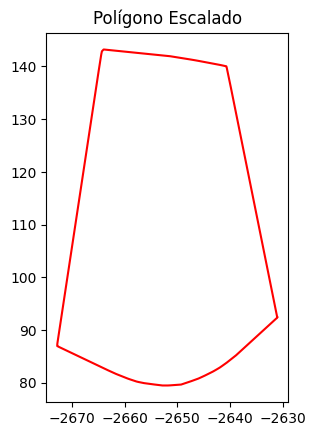

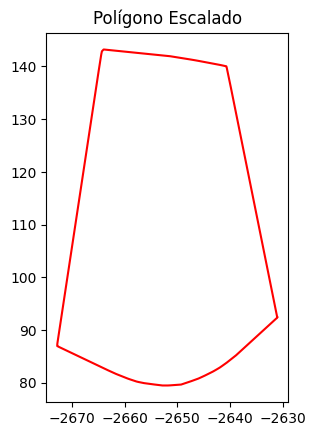

In [30]:
# Definir las nuevas dimensiones deseadas
ancho_L = 41.7  # Ancho objetivo
largo_L = 63.7  # Alto objetivo

# Calcular el área para la talla L
area_L = calcular_area_talla_diferente(área_S , largo_S, ancho_S, largo_L, ancho_L)
print("Área estimada para la talla L:", area_L, "cm²")

# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(polygon, ancho_L, largo_L, camisa_talla_l_ml)
poligono_escalado1 = cambiar_dimensiones_poligono(polygon, ancho_L, largo_L, camisa_talla_l_ml)

# Talla XL

Área estimada para la talla L: 2096.9480735987704 cm²


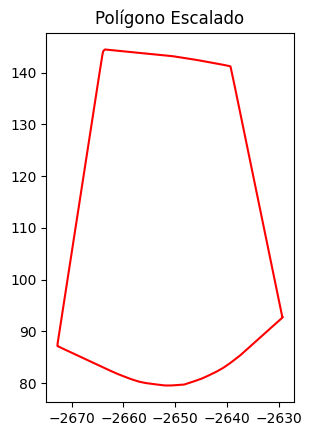

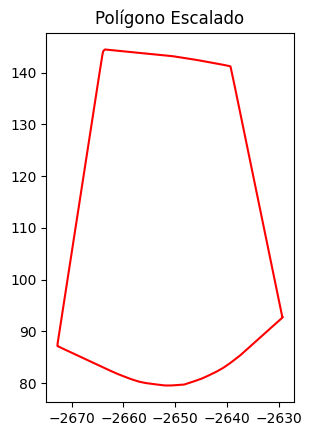

In [31]:
# Definir las nuevas dimensiones deseadas
ancho_XL = 43.5  # Ancho objetivo
largo_XL = 65  # Alto objetivo

# Calcular el área para la talla L
area_XL = calcular_area_talla_diferente(área_S , largo_S, ancho_S, largo_XL, ancho_XL)
print("Área estimada para la talla L:", area_XL, "cm²")

# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(polygon, ancho_XL, largo_XL, camisa_talla_xl_ml)
poligono_escalado1 = cambiar_dimensiones_poligono(polygon, ancho_XL, largo_XL, camisa_talla_xl_ml)

## Talla 2XL

Área estimada para la talla L: 2202.629806750963 cm²


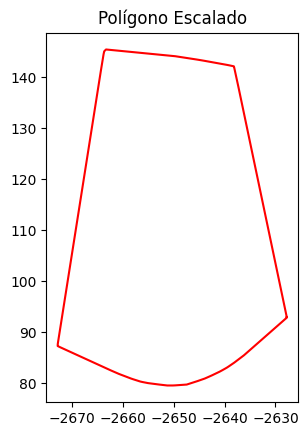

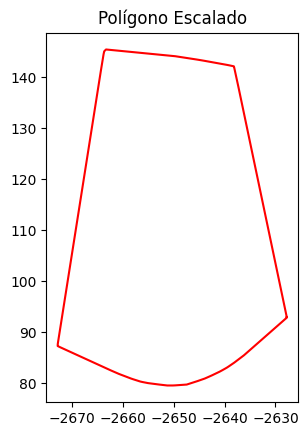

In [32]:
# Definir las nuevas dimensiones deseadas
ancho_2XL = 45 # Ancho objetivo
largo_2XL = 66  # Alto objetivo

# Calcular el área para la talla L
area_2XL = calcular_area_talla_diferente(área_S , largo_S, ancho_S, largo_2XL, ancho_2XL)
print("Área estimada para la talla L:", area_2XL, "cm²")

# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(polygon, ancho_2XL, largo_2XL, camisa_talla_2xl_ml)
poligono_escalado1 = cambiar_dimensiones_poligono(polygon, ancho_2XL, largo_2XL, camisa_talla_2xl_ml)

In [33]:
def calcular_relacion_pixeles_cm(imagen_ruta, ancho_real_cm, largo_real_cm):
    # Cargar la imagen
    imagen = cv2.imread(imagen_ruta)

    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    # Aplicar un filtro gaussiano para suavizar la imagen
    gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Aplicar un umbral adaptativo para binarizar la imagen
    th = cv2.adaptiveThreshold(gray_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV, 11, 2)

    # Encontrar los contornos en la imagen binarizada
    contornos, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Suponiendo que deseas trabajar con el contorno más grande
    cnt = max(contornos, key=cv2.contourArea)

    # Suavizar el contorno utilizando B-splines
    contorno_suavizado = suavizar_contorno(cnt, s=0.01)

    # Crear una imagen en blanco para dibujar el contorno suavizado
    imagen_rellena = np.zeros_like(imagen)
    imagen_rellena = cv2.cvtColor(imagen_rellena, cv2.COLOR_BGR2RGB)

    # Dibujar y rellenar el contorno suavizado directamente
    contorno_suavizado_int = contorno_suavizado.astype(np.int32)

    # Asegurarse de que el contorno es un polígono cerrado
    if not np.array_equal(contorno_suavizado_int[0], contorno_suavizado_int[-1]):
        contorno_suavizado_int = np.vstack([contorno_suavizado_int, contorno_suavizado_int[0]])

    # Rellenar el área dentro del contorno suavizado
    cv2.fillPoly(imagen_rellena, [contorno_suavizado_int], (255, 0, 0))

    # Identificar los puntos más a la izquierda, derecha, superior e inferior del contorno suavizado
    x_min = np.min(contorno_suavizado[:, 0])
    x_max = np.max(contorno_suavizado[:, 0])
    y_min = np.min(contorno_suavizado[:, 1])
    y_max = np.max(contorno_suavizado[:, 1])

    # Calcular el ancho y alto en píxeles usando los puntos extremos
    ancho_pixeles = x_max - x_min
    largo_pixeles = y_max - y_min

    # Calcular la relación de píxeles a centímetros
    pixeles_por_cm_ancho = ancho_pixeles / ancho_real_cm
    pixeles_por_cm_alto = largo_pixeles / largo_real_cm

    # Calcular la relación de píxeles/cm²
    pixeles_por_cm2_total = pixeles_por_cm_ancho * pixeles_por_cm_alto

    # Calcular el área en píxeles cuadrados
    poligono = Polygon(contorno_suavizado)
    area_pixeles = poligono.area

    # Obtener las dimensiones de la imagen
    alto, ancho, _ = imagen.shape

    # Calcular el número total de píxeles en la imagen
    pixeles_totales = alto * ancho

    # Convertir el área en píxeles cuadrados a centímetros cuadrados
    area_cm_cuadrados = area_pixeles / pixeles_por_cm2_total

    relacion_porcentual = (area_pixeles / pixeles_totales) * 100

    # Mostrar la imagen con el área rellenada
    plt.figure(figsize=(5, 5))
    plt.imshow(imagen_rellena)
    plt.axis('off')
    plt.title('Contorno Suavizado y Rellenado con B-splines')
    plt.show()

    # Imprimir información del polígono y relación de píxeles a cm²
    print(f"Ancho en píxeles: {ancho_pixeles}")
    print(f"Largo en píxeles: {largo_pixeles}")
    print(f"Área de toda la figura en pixeles: {pixeles_totales}")
    print(f"Relación píxeles/cm (ancho): {pixeles_por_cm_ancho:.2f}")
    print(f"Relación píxeles/cm (alto): {pixeles_por_cm_alto:.2f}")
    print(f"Área en píxeles cuadrados: {area_pixeles:.2f}")
    print(f"Relación píxeles/cm²: {pixeles_por_cm2_total:.2f}")
    print(f"Área en centímetros cuadrados: {area_cm_cuadrados:.2f} cm²")
    print(f"Relación porcentual: {relacion_porcentual:.2f}%")

    return area_cm_cuadrados

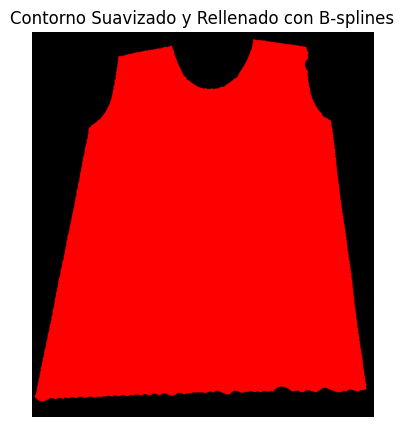

Ancho en píxeles: 1098.121226451473
Largo en píxeles: 1203.1286368268368
Área de toda la figura en pixeles: 1451520
Relación píxeles/cm (ancho): 21.87
Relación píxeles/cm (alto): 16.26
Área en píxeles cuadrados: 989415.76
Relación píxeles/cm²: 355.65
Área en centímetros cuadrados: 2781.97 cm²
Relación porcentual: 68.16%


2781.9666047872

In [34]:
# Ejemplo de uso
imagen_ruta = 'inputs/Delantero.jpeg'
ancho_S = 50.2  # Reemplaza con el ancho real en cm
largo_S = 74  # Reemplaza con el largo real en cm

calcular_relacion_pixeles_cm(imagen_ruta, ancho_S, largo_S)

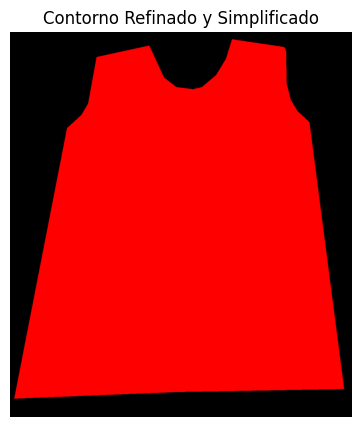

Coordenadas del contorno simplificado: [[909, 50], [736, 24], [716, 89], [683, 143], [636, 183], [606, 190], [551, 183], [510, 151], [461, 45], [287, 83], [259, 237], [237, 275], [189, 319], [14, 1218], [553, 1196], [1107, 1186], [992, 299], [953, 263], [930, 225], [916, 168], [915, 64], [909, 50]]


In [35]:
def detect_curvature(contour, window_size=5):
    """
    Detecta la curvatura del contorno.
    :param contour: Contorno a analizar.
    :param window_size: Tamaño de la ventana para calcular la curvatura.
    :return: Indices de puntos con alta curvatura.
    """
    curvature = []
    for i in range(len(contour)):
        p_prev = contour[i - window_size]
        p_curr = contour[i]
        p_next = contour[(i + window_size) % len(contour)]

        v1 = p_curr - p_prev
        v2 = p_next - p_curr

        cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        curvature.append(1 - cos_theta)

    curvature = np.array(curvature)
    high_curvature_indices = np.where(curvature > np.percentile(curvature, 95))[0]

    return high_curvature_indices

def refine_contour(contour, high_curvature_indices):
    """
    Refina el contorno manteniendo los puntos de alta curvatura.
    """
    refined_contour = []
    for i in range(len(contour)):
        if i in high_curvature_indices:
            refined_contour.append(contour[i])
        else:
            if len(refined_contour) == 0 or np.linalg.norm(np.array(refined_contour[-1]) - np.array(contour[i])) > 1:
                refined_contour.append(contour[i])
    return np.array(refined_contour)

def simplify_contour(contour, epsilon=1):
    """
    Simplifica el contorno utilizando el algoritmo Ramer-Douglas-Peucker.
    :param contour: Contorno a simplificar.
    :param epsilon: Tolerancia de simplificación.
    :return: Contorno simplificado.
    """
    simplified_contour = cv2.approxPolyDP(contour, epsilon, closed=True)
    return simplified_contour[:, 0, :]  # Remover una dimensión innecesaria

# Cargar la imagen
imagen = cv2.imread('inputs/Delantero.jpeg')

# Convertir la imagen a escala de grises
gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

# Aplicar un filtro gaussiano para suavizar la imagen
gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Aplicar un umbral adaptativo para binarizar la imagen
th = cv2.adaptiveThreshold(gray_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                           cv2.THRESH_BINARY_INV, 11, 2)

# Encontrar los contornos en la imagen binarizada
contornos, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Suponiendo que deseas trabajar con el contorno más grande
cnt = max(contornos, key=cv2.contourArea)[:, 0, :]  # Quitar una dimensión innecesaria

# Detectar puntos de alta curvatura
curvature_indices = detect_curvature(cnt, window_size=5)

# Refinar el contorno manteniendo las curvas importantes
contorno_refinado = refine_contour(cnt, curvature_indices)

# Simplificar el contorno refinado
contorno_simplificado = simplify_contour(contorno_refinado, epsilon=5.0)
poligono = Polygon(contorno_simplificado)

# Asegurarse de que el contorno es un polígono cerrado
if not np.array_equal(contorno_simplificado[0], contorno_simplificado[-1]):
    contorno_simplificado = np.vstack([contorno_simplificado, contorno_simplificado[0]])

# Crear una imagen en blanco para dibujar el contorno refinado y simplificado
imagen_rellena = np.zeros_like(imagen)
imagen_rellena = cv2.cvtColor(imagen_rellena, cv2.COLOR_BGR2RGB)

# Rellenar el área dentro del contorno refinado y simplificado
cv2.fillPoly(imagen_rellena, [np.array(contorno_simplificado, dtype=np.int32)], (255, 0, 0))

# Mostrar la imagen con el área rellenada
plt.figure(figsize=(5, 5))
plt.imshow(imagen_rellena)
plt.axis('off')
plt.title('Contorno Refinado y Simplificado')
plt.show()

# Imprimir las coordenadas del contorno refinado y simplificado
print("Coordenadas del contorno simplificado:", contorno_simplificado.tolist())

## Talla S

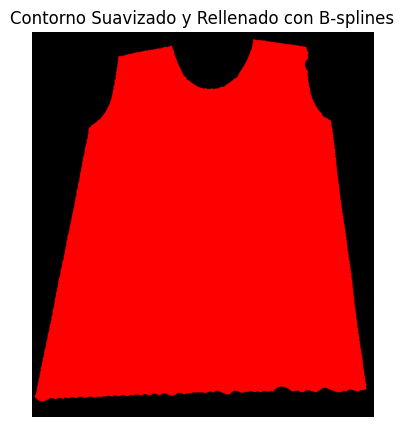

Ancho en píxeles: 1098.121226451473
Largo en píxeles: 1203.1286368268368
Área de toda la figura en pixeles: 1451520
Relación píxeles/cm (ancho): 21.96
Relación píxeles/cm (alto): 16.26
Área en píxeles cuadrados: 989415.76
Relación píxeles/cm²: 357.08
Área en centímetros cuadrados: 2770.88 cm²
Relación porcentual: 68.16%
Área estimada para la talla S: 2770.8830724972113 cm²


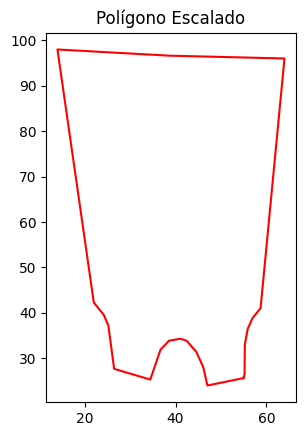

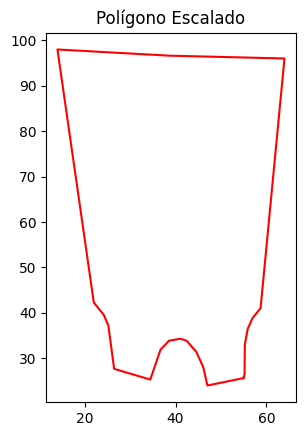

In [36]:
# Definir las nuevas dimensiones deseadas
ancho_S = 50  # Ancho objetivo
largo_S = 74 # Alto objetivo

área_S = calcular_relacion_pixeles_cm(imagen_ruta, ancho_S, largo_S)
print("Área estimada para la talla S:", área_S, "cm²")

# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(poligono, ancho_S, largo_S, camisa_talla_s_mc)
poligono_escalado1 = cambiar_dimensiones_poligono(poligono, ancho_S, largo_S, camisa_talla_s_ml)

## Talla M

Área estimada para la talla M: 2988.060394395641 cm²


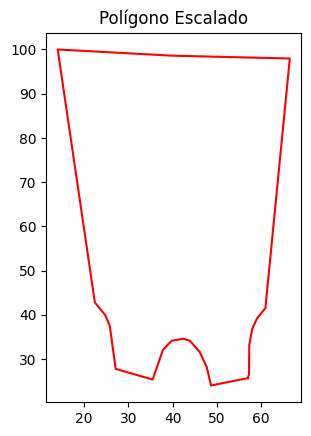

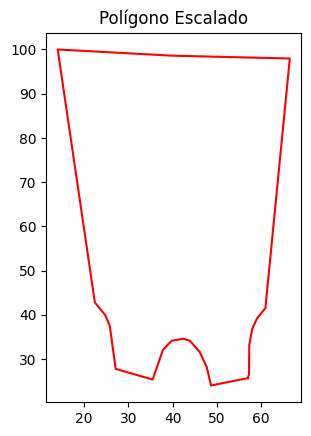

In [37]:
# Definir las nuevas dimensiones deseadas
ancho_M = 52.5  # Ancho objetivo
largo_M = 76  # Alto objetivo

# Calcular el área para la talla M
area_M = calcular_area_talla_diferente(área_S , largo_S, ancho_S, largo_M, ancho_M)
print("Área estimada para la talla M:", area_M, "cm²")
# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(poligono, ancho_M, largo_M, camisa_talla_m_mc)
poligono_escalado1 = cambiar_dimensiones_poligono(poligono, ancho_M, largo_M, camisa_talla_m_ml)

## Talla L

Área estimada para la talla L: 3212.7265894629827 cm²


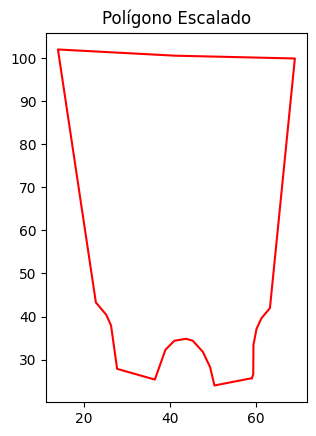

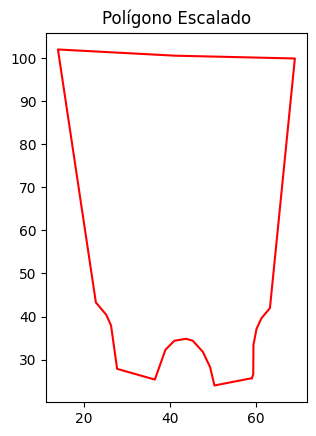

In [38]:
# Definir las nuevas dimensiones deseadas
ancho_L = 55  # Ancho objetivo
largo_L = 78  # Alto objetivo

# Calcular el área para la talla L
area_L = calcular_area_talla_diferente(área_S , largo_S, ancho_S, largo_L, ancho_L)
print("Área estimada para la talla L:", area_L, "cm²")

# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(poligono, ancho_L, largo_L, camisa_talla_l_mc)
poligono_escalado1 = cambiar_dimensiones_poligono(poligono, ancho_L, largo_L, camisa_talla_l_ml)

## Talla XL

Área estimada para la talla L: 3474.837150374881 cm²


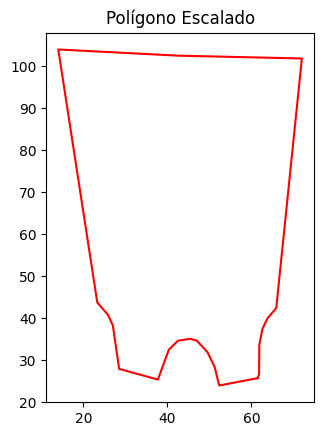

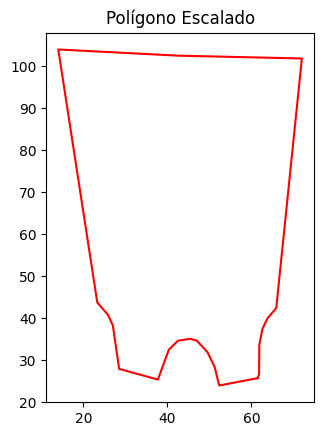

In [39]:
# Definir las nuevas dimensiones deseadas
ancho_XL = 58  # Ancho objetivo
largo_XL = 80  # Alto objetivo

# Calcular el área para la talla L
area_XL = calcular_area_talla_diferente(área_S , largo_S, ancho_S, largo_XL, ancho_XL)
print("Área estimada para la talla L:", area_XL, "cm²")

# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(poligono, ancho_XL, largo_XL, camisa_talla_xl_mc)
poligono_escalado1 = cambiar_dimensiones_poligono(poligono, ancho_XL, largo_XL, camisa_talla_xl_ml)

#Talla 2XL

Área estimada para la talla L: 3792.2530396391903 cm²


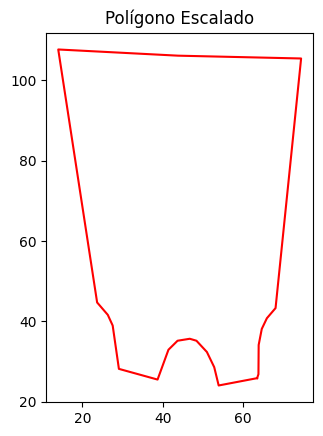

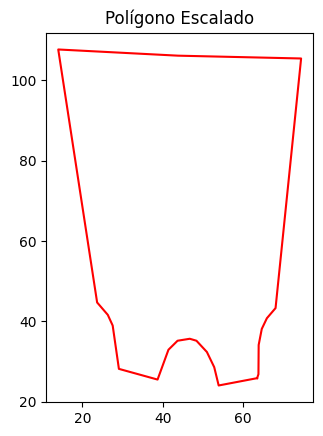

In [40]:
# Definir las nuevas dimensiones deseadas
ancho_2XL = 60.5 # Ancho objetivo
largo_2XL = 83.7  # Alto objetivo

# Calcular el área para la talla L
area_2XL = calcular_area_talla_diferente(área_S , largo_S, ancho_S, largo_2XL, ancho_2XL)
print("Área estimada para la talla L:", area_2XL, "cm²")

# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(poligono, ancho_2XL, largo_2XL, camisa_talla_2xl_mc)
poligono_escalado1 = cambiar_dimensiones_poligono(poligono, ancho_2XL, largo_2XL, camisa_talla_2xl_ml)

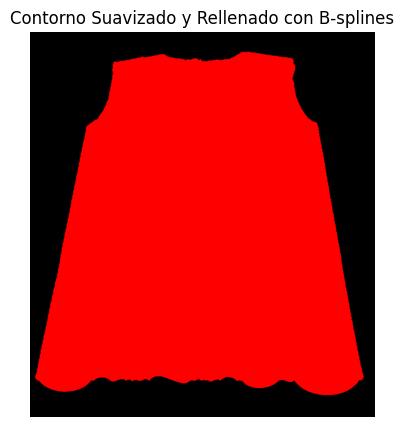

Ancho en píxeles: 1090.9118450202004
Largo en píxeles: 1141.056078812971
Área de toda la figura en pixeles: 1466880
Relación píxeles/cm (ancho): 21.73
Relación píxeles/cm (alto): 15.42
Área en píxeles cuadrados: 941937.75
Relación píxeles/cm²: 335.09
Área en centímetros cuadrados: 2811.00 cm²
Relación porcentual: 64.21%


2811.000967508092

In [41]:
# Ejemplo de uso
imagen_ruta = 'inputs/Espalda def.jpeg'
ancho_real_cm = 50.2  # Reemplaza con el ancho real en cm
largo_real_cm = 74  # Reemplaza con el largo real en cm

calcular_relacion_pixeles_cm(imagen_ruta, ancho_real_cm, largo_real_cm)

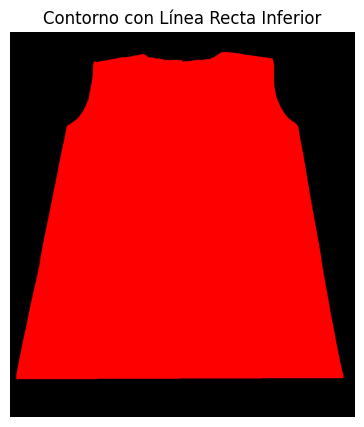

In [42]:
# Cargar la imagen
imagen = cv2.imread('inputs/Espalda def.jpeg')

# Convertir la imagen a escala de grises
gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

# Aplicar un filtro gaussiano para suavizar la imagen
gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Aplicar un umbral adaptativo para binarizar la imagen
th = cv2.adaptiveThreshold(gray_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv2.THRESH_BINARY_INV, 11, 2)

# Encontrar los contornos en la imagen binarizada
contornos, hierarchy = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Suponiendo que deseas trabajar con el contorno más grande
cnt = max(contornos, key=cv2.contourArea)

# Convertir el contorno a formato adecuado
cnt = cnt[:, 0, :]  # quitar una dimensión innecesaria

# Identificar los puntos más a la izquierda y derecha en la parte inferior del contorno
y_max = np.max(cnt[:, 1])
indices_inferiores = np.where(cnt[:, 1] >= y_max - 10)[0]

# Obtener los puntos inicial y final de la parte inferior
punto_inicio = cnt[indices_inferiores[0]]
punto_fin = cnt[indices_inferiores[-1]]

# Crear la línea recta inferior
linea_inferior = np.linspace(punto_inicio, punto_fin, 100).astype(np.int32)

# Dividir el contorno en la parte superior y el resto
contorno_superior = cnt[:indices_inferiores[0] + 1]
contorno_inferior = linea_inferior

# Unir la parte superior con la línea inferior y el resto del contorno
nuevo_contorno = np.vstack([contorno_superior, contorno_inferior, cnt[indices_inferiores[-1] + 1:]])

# Crear una imagen en blanco para dibujar el nuevo contorno
imagen_rellena = np.zeros_like(imagen)
imagen_rellena = cv2.cvtColor(imagen_rellena, cv2.COLOR_BGR2RGB)

# Dibujar y rellenar el nuevo contorno directamente
nuevo_contorno_int = nuevo_contorno.astype(np.int32)

# Asegurarse de que el contorno es un polígono cerrado
if not np.array_equal(nuevo_contorno_int[0], nuevo_contorno_int[-1]):
    nuevo_contorno_int = np.vstack([nuevo_contorno_int, nuevo_contorno_int[0]])

# Rellenar el área dentro del nuevo contorno
cv2.fillPoly(imagen_rellena, [nuevo_contorno_int], (255, 0, 0))

# Mostrar la imagen con el área rellenada
plt.figure(figsize=(5, 5))
plt.imshow(imagen_rellena)
plt.axis('off')
plt.title('Contorno con Línea Recta Inferior')
plt.show()

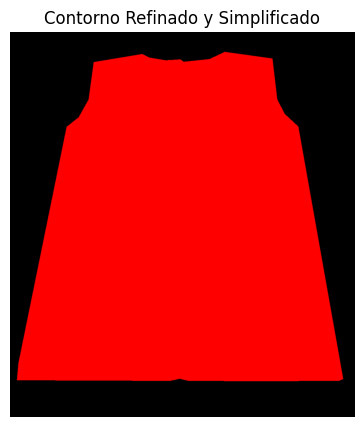

Coordenadas del contorno simplificado: [[871, 88], [713, 66], [662, 90], [576, 99], [566, 91], [516, 94], [462, 85], [439, 73], [278, 100], [261, 224], [228, 283], [188, 315], [28, 1100], [23, 1157], [531, 1159], [563, 1152], [593, 1159], [825, 1160], [1092, 1159], [1106, 1153], [957, 314], [912, 272], [887, 224], [871, 88]]


In [43]:
# Cargar la imagen
imagen = cv2.imread('inputs/Espalda def.jpeg')

# Convertir la imagen a escala de grises
gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

# Aplicar un filtro gaussiano para suavizar la imagen
gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Aplicar un umbral adaptativo para binarizar la imagen
th = cv2.adaptiveThreshold(gray_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                           cv2.THRESH_BINARY_INV, 11, 2)

# Encontrar los contornos en la imagen binarizada
contornos, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Suponiendo que deseas trabajar con el contorno más grande
cnt = max(contornos, key=cv2.contourArea)[:, 0, :]  # Quitar una dimensión innecesaria

# Detectar puntos de alta curvatura
curvature_indices = detect_curvature(cnt, window_size=5)

# Refinar el contorno manteniendo las curvas importantes
contorno_refinado = refine_contour(cnt, curvature_indices)

# Simplificar el contorno refinado
contorno_simplificado = simplify_contour(contorno_refinado, epsilon=5.0)
poligono = Polygon(contorno_simplificado)

# Asegurarse de que el contorno es un polígono cerrado
if not np.array_equal(contorno_simplificado[0], contorno_simplificado[-1]):
    contorno_simplificado = np.vstack([contorno_simplificado, contorno_simplificado[0]])

# Crear una imagen en blanco para dibujar el contorno refinado y simplificado
imagen_rellena = np.zeros_like(imagen)
imagen_rellena = cv2.cvtColor(imagen_rellena, cv2.COLOR_BGR2RGB)

# Rellenar el área dentro del contorno refinado y simplificado
cv2.fillPoly(imagen_rellena, [np.array(contorno_simplificado, dtype=np.int32)], (255, 0, 0))

# Mostrar la imagen con el área rellenada
plt.figure(figsize=(5, 5))
plt.imshow(imagen_rellena)
plt.axis('off')
plt.title('Contorno Refinado y Simplificado')
plt.show()

# Imprimir las coordenadas del contorno refinado y simplificado
print("Coordenadas del contorno simplificado:", contorno_simplificado.tolist())

## Talla S

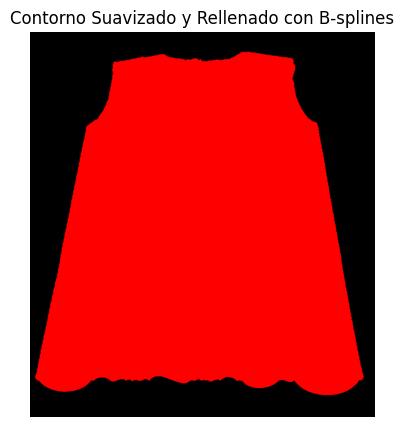

Ancho en píxeles: 1090.9118450202004
Largo en píxeles: 1141.056078812971
Área de toda la figura en pixeles: 1466880
Relación píxeles/cm (ancho): 21.82
Relación píxeles/cm (alto): 15.42
Área en píxeles cuadrados: 941937.75
Relación píxeles/cm²: 336.43
Área en centímetros cuadrados: 2799.80 cm²
Relación porcentual: 64.21%
Área estimada para la talla S: 2799.801760466227 cm²


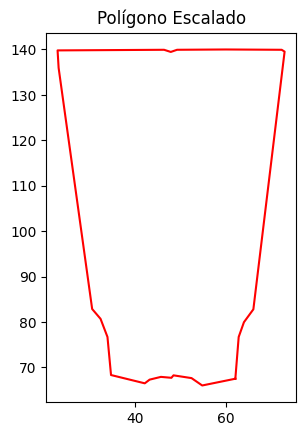

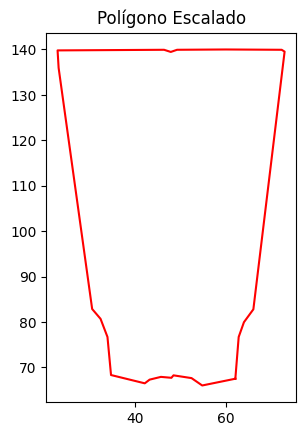

In [44]:
# Definir las nuevas dimensiones deseadas
ancho_S = 50  # Ancho objetivo
largo_S = 74 # Alto objetivo

área_S = calcular_relacion_pixeles_cm(imagen_ruta, ancho_S, largo_S)
print("Área estimada para la talla S:", área_S, "cm²")

# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(poligono, ancho_S, largo_S, camisa_talla_s_mc)
poligono_escalado1 = cambiar_dimensiones_poligono(poligono, ancho_S, largo_S, camisa_talla_s_ml)

## Talla M

Área estimada para la talla M: 3019.245682232499 cm²


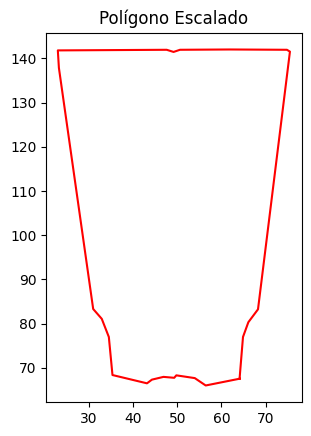

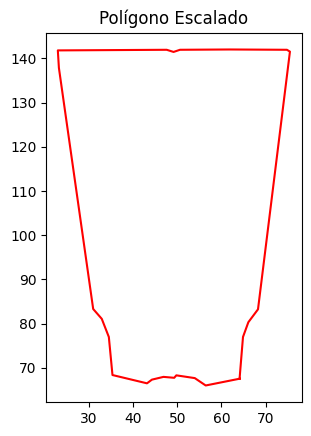

In [45]:
# Definir las nuevas dimensiones deseadas
ancho_M = 52.5  # Ancho objetivo
largo_M = 76  # Alto objetivo

# Calcular el área para la talla M
area_M = calcular_area_talla_diferente(área_S , largo_S, ancho_S, largo_M, ancho_M)
print("Área estimada para la talla M:", area_M, "cm²")
# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(poligono, ancho_M, largo_M, camisa_talla_m_mc)
poligono_escalado1 = cambiar_dimensiones_poligono(poligono, ancho_M, largo_M, camisa_talla_m_ml)

## Talla L

Área estimada para la talla L: 3306.913962572726 cm²


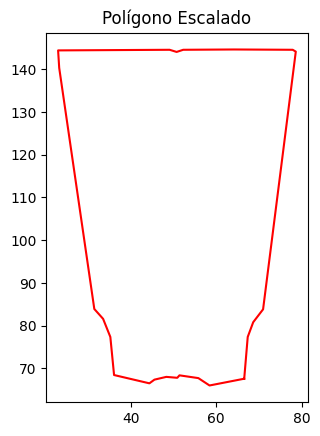

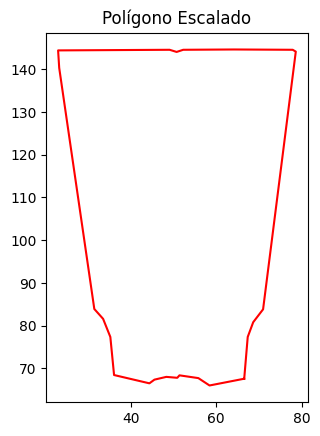

In [46]:
# Definir las nuevas dimensiones deseadas
ancho_L = 55.6  # Ancho objetivo
largo_L = 78.6  # Alto objetivo

# Calcular el área para la talla L
area_L = calcular_area_talla_diferente(área_S , largo_S, ancho_S, largo_L, ancho_L)
print("Área estimada para la talla L:", area_L, "cm²")

# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(poligono, ancho_L, largo_L, camisa_talla_l_mc)
poligono_escalado1 = cambiar_dimensiones_poligono(poligono, ancho_L, largo_L, camisa_talla_l_ml)

## Talla XL

Área estimada para la talla L: 3511.102748260349 cm²


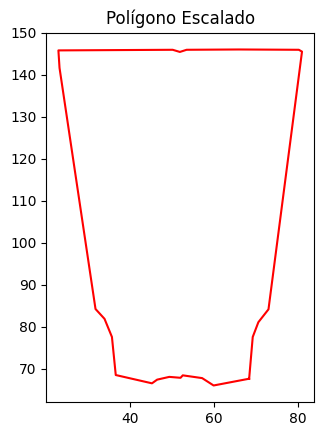

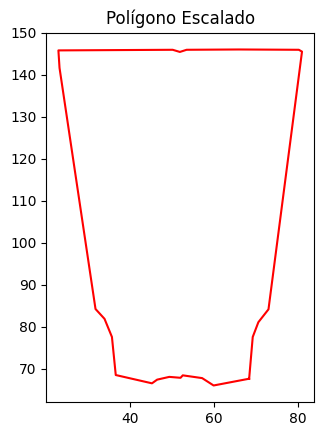

In [47]:
# Definir las nuevas dimensiones deseadas
ancho_XL = 58  # Ancho objetivo
largo_XL = 80  # Alto objetivo

# Calcular el área para la talla L
area_XL = calcular_area_talla_diferente(área_S , largo_S, ancho_S, largo_XL, ancho_XL)
print("Área estimada para la talla L:", area_XL, "cm²")

# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(poligono, ancho_XL, largo_XL, camisa_talla_xl_mc)
poligono_escalado1 = cambiar_dimensiones_poligono(poligono, ancho_XL, largo_XL, camisa_talla_xl_ml)

## Talla 2XL

Área estimada para la talla L: 3831.8313904694337 cm²


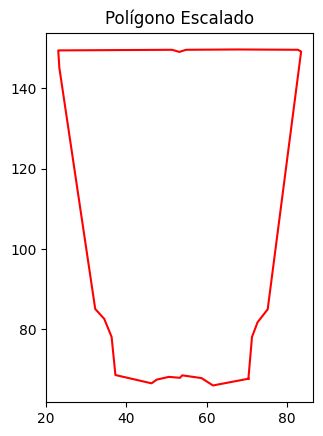

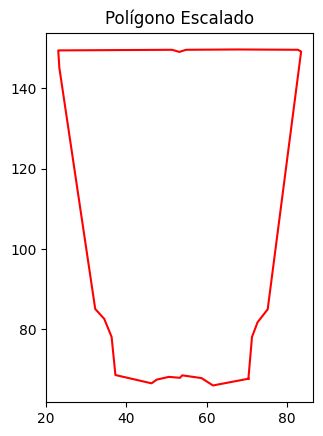

In [48]:
# Definir las nuevas dimensiones deseadas
ancho_2XL = 60.5 # Ancho objetivo
largo_2XL = 83.7  # Alto objetivo

# Calcular el área para la talla L
area_2XL = calcular_area_talla_diferente(área_S , largo_S, ancho_S, largo_2XL, ancho_2XL)
print("Área estimada para la talla L:", area_2XL, "cm²")

# Cambiar las dimensiones del polígono
poligono_escalado = cambiar_dimensiones_poligono(poligono, ancho_2XL, largo_2XL, camisa_talla_2xl_mc)
poligono_escalado1 = cambiar_dimensiones_poligono(poligono, ancho_2XL, largo_2XL, camisa_talla_2xl_ml)

## Heurística de First Fit-Decreasing

In [49]:
for i, poly in enumerate(camisa_talla_m_mc):
    print(f"Polígono {i}: {poly}")

Polígono 0: [[572.7351684570312, 281.2869332396685], [572.6666484596204, 294.7184409523173], [572.5583846670545, 294.8304411147541], [572.204484450521, 294.9228754897001], [571.0986153116345, 295.0070338950983], [569.6283020042428, 295.06621902939014], [565.8188788516444, 295.15480291421085], [539.7842123721504, 295.5], [535.5134921053134, 295.44365104887095], [533.6294973548859, 295.40315306673926], [533.3521529765403, 295.362299754143], [533.3425237751638, 295.08366252492425], [533.2351684570312, 281.0925480938795], [534.3769874512116, 280.1819564409679], [540.7551252019618, 275.7640366740594], [542.9879356932736, 274.26890379496894], [543.6006193238894, 273.8714250805163], [544.5488877616095, 273.33713081230655], [545.5287017580185, 272.8625247940237], [545.8493618521535, 272.7082685712248], [546.1791239500662, 272.56467751156345], [547.1807648684808, 272.19046809712563], [547.5243078488589, 272.0743610413306], [548.2132750891409, 271.84578704807933], [548.8763233498665, 271.6607192

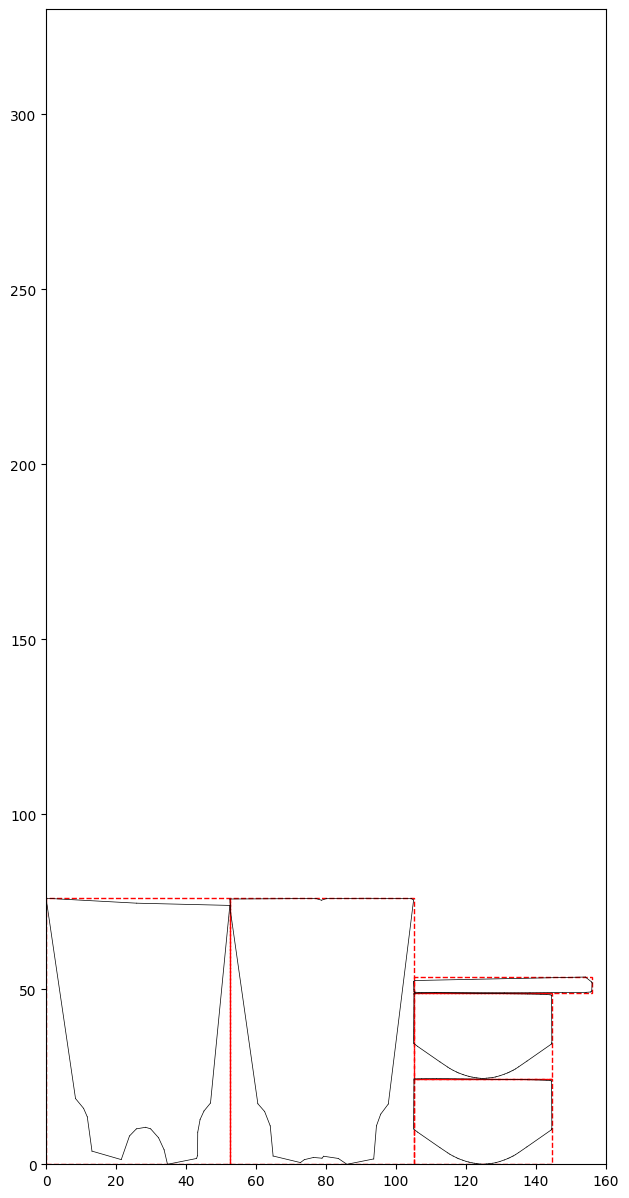

In [59]:
import matplotlib.pyplot as plt
from rectpack import newPacker
import matplotlib.patches as patches
import copy  # Importa copy para deepcopy

def slidePoly(poly, x, y):
    new_poly = [[point[0] + x, point[1] + y] for point in poly]
    return new_poly

def addLine(line, **kw):
    if len(kw) == 0:
        plt.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], color="black", linewidth=0.5)
    else:
        plt.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], color=kw["color"], linewidth=0.5)

def addPolygon(poly):
    for i in range(len(poly)):
        if i == len(poly) - 1:
            addLine([poly[i], poly[0]])
        else:
            addLine([poly[i], poly[i + 1]])

def calculate_bounding_box(poly):
    left = min(point[0] for point in poly)
    right = max(point[0] for point in poly)
    bottom = min(point[1] for point in poly)
    top = max(point[1] for point in poly)
    return (left, bottom, right, top)

def draw_bounding_box(poly, ax, color='red'):
    left, bottom, right, top = calculate_bounding_box(poly)
    width = right - left
    height = top - bottom
    bbox = patches.Rectangle((left, bottom), width, height, linewidth=1, edgecolor=color, facecolor='none', linestyle='--')
    ax.add_patch(bbox)

def render_polygons_with_bboxes(polygons, canvas_width=8000, canvas_height=8000):
    # Aumentar el tamaño de la figura para mejorar la visualización
    fig, ax = plt.subplots(figsize=(12, 15))  # Puedes ajustar las dimensiones según necesites
    for poly in polygons:
        addPolygon(poly)
        draw_bounding_box(poly, ax, color='red')
    plt.xlim(0, canvas_width)
    plt.ylim(0, canvas_height)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def sort_polygons_by_bounding_box_area(polygons):
    def bounding_box_area(poly):
        left, bottom, right, top = calculate_bounding_box(poly)
        return (right - left) * (top - bottom)
    return sorted(polygons, key=bounding_box_area, reverse=True)


def sort_polygons_by_bounding_box_area(polygons):
    def bounding_box_area(poly):
        left, bottom, right, top = calculate_bounding_box(poly)
        return (right - left) * (top - bottom)
    return sorted(polygons, key=bounding_box_area, reverse=True)

def pack_bounding_boxes_with_rectpack(camisa_talla_s_mc, canvas_width, canvas_height):
    packer = newPacker(rotation=False)
    for poly in camisa_talla_s_mc:
        left, bottom, right, top = calculate_bounding_box(poly)
        width = right - left
        height = top - bottom
        packer.add_rect(width, height)
    packer.add_bin(canvas_width, canvas_height)
    packer.pack()
    positions = []
    for abin in packer:
        for rect in abin:
            x_pos = rect.x
            y_pos = rect.y
            positions.append((x_pos, y_pos, rect.width, rect.height))
    return positions

def apply_positions_to_polygons(polys, positions):
    moved_polys = []
    for i, poly in enumerate(polys):
        x_pos, y_pos, width, height = positions[i]
        left, bottom, right, top = calculate_bounding_box(poly)
        shift_x = x_pos - left
        shift_y = y_pos - bottom
        new_poly = slidePoly(poly, shift_x, shift_y)
        moved_polys.append(new_poly)
    return moved_polys

# Ejemplo de uso:
canvas_width = 160
canvas_height = 330

# Asegurándose de que los datos estén siendo añadidos correctamente
test_polys = []
for i in range(min(len(camisa_talla_m_mc), len(camisa_talla_l_mc), len(camisa_talla_xl_mc), len(camisa_talla_2xl_mc))):
    test_polys.extend([
        copy.deepcopy(camisa_talla_m_mc[i]),
        copy.deepcopy(camisa_talla_l_mc[i]),
        copy.deepcopy(camisa_talla_xl_mc[i]),
        copy.deepcopy(camisa_talla_2xl_mc[i])
    ])

sorted_test_polys = sort_polygons_by_bounding_box_area(camisa_talla_m_mc)
positions = pack_bounding_boxes_with_rectpack(sorted_test_polys, canvas_width, canvas_height)
moved_polys = apply_positions_to_polygons(sorted_test_polys, positions)
render_polygons_with_bboxes(moved_polys, canvas_width, canvas_height)

In [60]:
camisa_talla_m_mc

[[[572.7351684570312, 281.2869332396685],
  [572.6666484596204, 294.7184409523173],
  [572.5583846670545, 294.8304411147541],
  [572.204484450521, 294.9228754897001],
  [571.0986153116345, 295.0070338950983],
  [569.6283020042428, 295.06621902939014],
  [565.8188788516444, 295.15480291421085],
  [539.7842123721504, 295.5],
  [535.5134921053134, 295.44365104887095],
  [533.6294973548859, 295.40315306673926],
  [533.3521529765403, 295.362299754143],
  [533.3425237751638, 295.08366252492425],
  [533.2351684570312, 281.0925480938795],
  [534.3769874512116, 280.1819564409679],
  [540.7551252019618, 275.7640366740594],
  [542.9879356932736, 274.26890379496894],
  [543.6006193238894, 273.8714250805163],
  [544.5488877616095, 273.33713081230655],
  [545.5287017580185, 272.8625247940237],
  [545.8493618521535, 272.7082685712248],
  [546.1791239500662, 272.56467751156345],
  [547.1807648684808, 272.19046809712563],
  [547.5243078488589, 272.0743610413306],
  [548.2132750891409, 271.8457870480793

In [51]:
moved_polys

[[[49.540256175663316, 1.8226130653266317],
  [39.964318389752975, 0.0],
  [38.857273559011894, 4.556532663316581],
  [37.030649588289116, 8.341959798994978],
  [34.429094236047575, 11.14597989949749],
  [32.76852698993596, 11.636683417085429],
  [29.72415370539799, 11.14597989949749],
  [27.454711802378775, 8.902763819095476],
  [24.742451967063133, 1.4721105527638194],
  [15.111161939615737, 4.135929648241206],
  [13.561299176578224, 14.93140703517588],
  [12.343549862763041, 17.595226130653266],
  [9.68664226898445, 20.67964824120603],
  [0.0, 83.70000000000002],
  [29.834858188472097, 82.15778894472362],
  [60.5, 81.456783919598],
  [54.134492223238794, 19.277638190954775],
  [51.97575480329368, 16.754020100502515],
  [50.70265324794144, 14.090201005025122],
  [49.927721866422694, 10.094472361809046],
  [49.872369624885636, 2.8040201005025125],
  [49.540256175663316, 1.8226130653266317]],
 [[107.87211449676823, 1.6831809872029169],
  [99.04570637119113, 0.0],
  [96.19667590027701, 

In [52]:
# print(
# 	len(camisa_talla_s_mc),
# 	len(camisa_talla_s_ml),
# 	len(camisa_talla_m_mc),
# 	len(camisa_talla_m_ml),
# 	len(camisa_talla_l_mc),
# 	len(camisa_talla_l_ml),
# 	len(camisa_talla_xl_mc),
# 	len(camisa_talla_xl_ml),
# 	len(camisa_talla_2xl_mc),
# 	len(camisa_talla_2xl_ml),
# )


models = [
	camisa_talla_s_mc,
	camisa_talla_s_ml,
	camisa_talla_m_mc,
	camisa_talla_m_ml,
	camisa_talla_l_mc,
	camisa_talla_l_ml,
	camisa_talla_xl_mc,
	camisa_talla_xl_ml,
	camisa_talla_2xl_mc,
	camisa_talla_2xl_ml,
]

print(len(models))

10


In [53]:
import pandas as pd

data = {
	"modelo": [
		"camisa_talla_s_mc",
		"camisa_talla_s_ml",
		"camisa_talla_m_mc",
		"camisa_talla_m_ml",
		"camisa_talla_l_mc",
		"camisa_talla_l_ml",
		"camisa_talla_xl_mc",
		"camisa_talla_xl_ml",
		"camisa_talla_2xl_mc",
		"camisa_talla_2xl_ml",
	],
	"molde_1": [x[0] for x in models],
	"molde_2": [x[1] for x in models],
	"molde_3": [x[2] for x in models],
	"molde_4": [x[3] for x in models],
	"molde_5": [x[4] for x in models],
}

models_df = pd.DataFrame(data)



In [54]:
models_df.to_csv('models.csv', index=False)

In [55]:


# def get_user_input():
#     # Suponemos que estas son las listas de polígonos disponibles
#     available_polygons = {
#         'camisa_talla_m_mc': [Polygon([(0, 0), (2, 0), (2, 2), (0, 2)])],
#         'camisa_talla_l_mc': [Polygon([(0, 0), (3, 0), (3, 3), (0, 3)])],
#         'camisa_talla_xl_mc': [Polygon([(0, 0), (4, 0), (4, 4), (0, 4)])],
#         'camisa_talla_2xl_mc': [Polygon([(0, 0), (5, 0), (5, 5), (0, 5)])]
#     }

#     selected_polygons = []
#     for key in available_polygons.keys():
#         # Preguntar al usuario si quiere incluir esta lista de polígonos
#         include = input(f"¿Quieres incluir polígonos de '{key}'? (s/n): ")
#         if include.lower() == 's':
#             # Preguntar cuántas veces quiere repetir esta lista
#             try:
#                 repeat_count = int(input(f"¿Cuántas veces quieres repetir los polígonos de '{key}'? "))
#                 for _ in range(repeat_count):
#                     selected_polygons.extend(copy.deepcopy(available_polygons[key]))
#             except ValueError:
#                 print("Número inválido. Saltando esta selección.")

#     return selected_polygons

# def main():
#     selected_polygons = get_user_input()
#     canvas_width = 160
#     canvas_height = 330

#     # Procedimientos adicionales, como ordenamiento, empaquetamiento, y visualización
#     sorted_test_polys = sort_polygons_by_bounding_box_area(selected_polygons)
#     positions = pack_bounding_boxes_with_rectpack(sorted_test_polys, canvas_width, canvas_height)
#     moved_polys = apply_positions_to_polygons(sorted_test_polys, positions)
#     render_polygons_with_bboxes(moved_polys, canvas_width, canvas_height)

# if __name__ == "__main__":
#     main()

In [56]:
# for i in range(len(camisa_talla_m_mc)):
#   print(f"Polígono {i}: {camisa_talla_m_mc[i]}")

In [57]:
# def slidePoly(poly, x, y):
#     new_poly = [[point[0] + x, point[1] + y] for point in poly]
#     return new_poly

# def addLine(line, **kw):
#     if len(kw) == 0:
#         plt.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], color="black", linewidth=0.5)
#     else:
#         plt.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], color=kw["color"], linewidth=0.5)

# def addPolygon(poly):
#     for i in range(len(poly)):
#         if i == len(poly) - 1:
#             addLine([poly[i], poly[0]])
#         else:
#             addLine([poly[i], poly[i + 1]])

# def calculate_bounding_box(poly):
#     left = min(point[0] for point in poly)
#     right = max(point[0] for point in poly)
#     bottom = min(point[1] for point in poly)
#     top = max(point[1] for point in poly)
#     return (left, bottom, right, top)


# def render_polygons_with_bboxes(polygons, canvas_width=8000, canvas_height=8000):
#     # Aumentar el tamaño de la figura para mejorar la visualización
#     fig, ax = plt.subplots(figsize=(12, 15))  # Puedes ajustar las dimensiones según necesites
#     for poly in polygons:
#         addPolygon(poly)
#     plt.xlim(-1, canvas_width)
#     plt.ylim(-1, canvas_height)
#     plt.gca().set_aspect('equal', adjustable='box')
#     plt.show()

# def sort_polygons_by_bounding_box_area(polygons):
#     def bounding_box_area(poly):
#         left, bottom, right, top = calculate_bounding_box(poly)
#         return (right - left) * (top - bottom)
#     return sorted(polygons, key=bounding_box_area, reverse=True)

# def pack_bounding_boxes_with_rectpack(camisa_talla_s_mc, canvas_width, canvas_height):
#     packer = newPacker(rotation=False)
#     for poly in camisa_talla_s_mc:
#         left, bottom, right, top = calculate_bounding_box(poly)
#         width = right - left
#         height = top - bottom
#         packer.add_rect(width, height)
#     packer.add_bin(canvas_width, canvas_height)
#     packer.pack()
#     positions = []
#     for abin in packer:
#         for rect in abin:
#             x_pos = rect.x
#             y_pos = rect.y
#             positions.append((x_pos, y_pos, rect.width, rect.height))
#     return positions

# def apply_positions_to_polygons(polys, positions):
#     moved_polys = []
#     for i, poly in enumerate(polys):
#         x_pos, y_pos, width, height = positions[i]
#         left, bottom, right, top = calculate_bounding_box(poly)
#         shift_x = x_pos - left
#         shift_y = y_pos - bottom
#         new_poly = slidePoly(poly, shift_x, shift_y)
#         moved_polys.append(new_poly)
#     return moved_polys

# # Example usage:
# canvas_width = 150
# canvas_height = 658

# # Using test polygons (make sure to use deepcopy to create independent polygons)
# test_polys = [
#     copy.deepcopy(camisa_talla_s_mc[0]),
#     copy.deepcopy(camisa_talla_s_mc[1]),
#     copy.deepcopy(camisa_talla_s_mc[2]),
#     copy.deepcopy(camisa_talla_s_mc[3]),
#     copy.deepcopy(camisa_talla_s_mc[4])
# ]

# sorted_polys = sort_polygons_by_bounding_box_area(test_polys)
# positions = pack_bounding_boxes_with_rectpack(sorted_polys, canvas_width, canvas_height)
# moved_polys = apply_positions_to_polygons(sorted_polys, positions)
# render_polygons_with_bboxes(moved_polys, canvas_width, canvas_height)